In [3]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

def get_image_paths(folder):
    img_dir = os.path.join(folder, "image")
    return [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith('.png')]

all_image_paths = []
for split in ["train", "val", "test"]:
    all_image_paths.extend(get_image_paths(split))

means = []
stds = []

for img_path in tqdm(all_image_paths, desc="Calculating mean/std"):
    img = Image.open(img_path).convert("RGB")
    img = np.array(img) / 255.0  # scale to [0,1]
    means.append(np.mean(img, axis=(0,1)))
    stds.append(np.std(img, axis=(0,1)))

mean = np.mean(means, axis=0)
std = np.mean(stds, axis=0)

print(f"Dataset mean: {mean}")
print(f"Dataset std: {std}")

Calculating mean/std: 100%|██████████| 300/300 [00:01<00:00, 199.84it/s]

Dataset mean: [0.11803523 0.12175034 0.12110489]
Dataset std: [0.16351671 0.16600904 0.16600859]


U-Net

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# -----------------------
# Dataset
# -----------------------
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])  # assumes same filename

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale

        if self.transform is not None:
            image = self.transform(image)
            # For mask: only resize and ToTensor, no Normalize!
            mask_transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor()
            ])
            mask = mask_transform(mask)

        mask = (mask > 0).float()  # binarize
        return image, mask

# -----------------------
# U-Net
# -----------------------
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.conv_final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.conv_final(d1))

# -----------------------
# Metrics
# -----------------------
def dice_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()
    intersection = (pred * target).sum()
    return ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)).item()

def iou_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return ((intersection + smooth) / (union + smooth)).item()

def pixel_accuracy(pred, target):
    pred = (pred > 0.5).float()
    correct = (pred == target).float().sum()
    return (correct / target.numel()).item()

def precision_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()
    tp = (pred * target).sum()
    fp = (pred * (1 - target)).sum()
    return (tp / (tp + fp + smooth)).item()

def recall_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()
    tp = (pred * target).sum()
    fn = ((1 - pred) * target).sum()
    return (tp / (tp + fn + smooth)).item()

# -----------------------
# Data Setup
# -----------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.11803523, 0.12175034, 0.12110489], std=[0.16351671, 0.16600904, 0.16600859])
])

train_dataset = SegmentationDataset(
    img_dir="train/image",
    mask_dir="train/mask",
    transform=transform
)
val_dataset = SegmentationDataset(
    img_dir="val/image",
    mask_dir="val/mask",
    transform=transform
)
test_dataset = SegmentationDataset(
    img_dir="test/image",
    mask_dir="test/mask",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

# -----------------------
# U-Net Training
# -----------------------
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
bce = nn.BCELoss()

num_epochs = 20
u_net_best_test_loss = float("inf")
patience = 5
epochs_no_improve = 0

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    u_net_train_loss, u_net_train_dice, u_net_train_iou, u_net_train_acc = 0, 0, 0, 0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        u_net_train_loss += loss.item()
        u_net_train_dice += dice_score(preds, masks)
        u_net_train_iou += iou_score(preds, masks)
        u_net_train_acc += pixel_accuracy(preds, masks)

    # --- Validation ---
    model.eval()
    u_net_val_loss, u_net_val_dice, u_net_val_iou, u_net_val_acc, u_net_val_prec, u_net_val_rec = 0, 0, 0, 0, 0, 0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))
            u_net_val_loss += loss.item()
            u_net_val_dice += dice_score(preds, masks)
            u_net_val_iou += iou_score(preds, masks)
            u_net_val_acc += pixel_accuracy(preds, masks)
            u_net_val_prec += precision_score(preds, masks)
            u_net_val_rec += recall_score(preds, masks)

    # --- Test ---
    u_net_test_loss, u_net_test_dice, u_net_test_iou, u_net_test_acc, u_net_test_prec, u_net_test_rec = 0, 0, 0, 0, 0, 0
    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Test"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))
            u_net_test_loss += loss.item()
            u_net_test_dice += dice_score(preds, masks)
            u_net_test_iou += iou_score(preds, masks)
            u_net_test_acc += pixel_accuracy(preds, masks)
            u_net_test_prec += precision_score(preds, masks)
            u_net_test_rec += recall_score(preds, masks)

    # --- Print metrics ---
    print(f"\nEpoch {epoch+1}:")
    print(f" Train Loss={u_net_train_loss/len(train_loader):.4f} | "
          f"Dice={u_net_train_dice/len(train_loader):.4f} | IoU={u_net_train_iou/len(train_loader):.4f} | Acc={u_net_train_acc/len(train_loader):.4f}")
    print(f" Val   Loss={u_net_val_loss/len(val_loader):.4f} | "
          f"Dice={u_net_val_dice/len(val_loader):.4f} | IoU={u_net_val_iou/len(val_loader):.4f} | Acc={u_net_val_acc/len(val_loader):.4f} | "
          f"Prec={u_net_val_prec/len(val_loader):.4f} | Recall={u_net_val_rec/len(val_loader):.4f}")
    print(f" Test  Loss={u_net_test_loss/len(test_loader):.4f} | "
          f"Dice={u_net_test_dice/len(test_loader):.4f} | IoU={u_net_test_iou/len(test_loader):.4f} | Acc={u_net_test_acc/len(test_loader):.4f} | "
          f"Prec={u_net_test_prec/len(test_loader):.4f} | Recall={u_net_test_rec/len(test_loader):.4f}")

    # --- Early stopping ---
    if u_net_test_loss < u_net_best_test_loss:
        u_net_best_test_loss = u_net_test_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_unet.pth")
        print("✅ Model saved!")
    else:
        epochs_no_improve += 1
        print(f"EarlyStopping counter: {epochs_no_improve} of {patience}")
        if epochs_no_improve >= patience:
            print("⏹️ Early stopping triggered!")
            break


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\cuda\__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5070 Ti with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5070 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(
Epoch 1/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 12.35it/s]



Epoch 1:
 Train Loss=0.7300 | Dice=0.0537 | IoU=0.0278 | Acc=0.9313
 Val   Loss=0.7502 | Dice=0.0133 | IoU=0.0067 | Acc=0.9853 | Prec=0.0092 | Recall=0.0251
 Test  Loss=0.7516 | Dice=0.0098 | IoU=0.0049 | Acc=0.9851 | Prec=0.0070 | Recall=0.0175
✅ Model saved!


Epoch 2/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 11.54it/s]



Epoch 2:
 Train Loss=0.6792 | Dice=0.0054 | IoU=0.0027 | Acc=0.9938
 Val   Loss=0.6611 | Dice=0.0235 | IoU=0.0122 | Acc=0.9942 | Prec=0.0408 | Recall=0.0166
 Test  Loss=0.6599 | Dice=0.0259 | IoU=0.0137 | Acc=0.9938 | Prec=0.0474 | Recall=0.0180
✅ Model saved!


Epoch 3/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 12.69it/s]



Epoch 3:
 Train Loss=0.6562 | Dice=0.0000 | IoU=0.0000 | Acc=0.9948
 Val   Loss=0.6557 | Dice=0.0078 | IoU=0.0039 | Acc=0.9949 | Prec=0.0221 | Recall=0.0047
 Test  Loss=0.6559 | Dice=0.0074 | IoU=0.0038 | Acc=0.9945 | Prec=0.0246 | Recall=0.0044
✅ Model saved!


Epoch 4/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 11.13it/s]



Epoch 4:
 Train Loss=0.6309 | Dice=0.0286 | IoU=0.0151 | Acc=0.9951
 Val   Loss=0.6280 | Dice=0.0396 | IoU=0.0208 | Acc=0.9950 | Prec=0.0990 | Recall=0.0249
 Test  Loss=0.6281 | Dice=0.0398 | IoU=0.0214 | Acc=0.9946 | Prec=0.1031 | Recall=0.0249
✅ Model saved!


Epoch 5/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 12.88it/s]



Epoch 5:
 Train Loss=0.5771 | Dice=0.1198 | IoU=0.0685 | Acc=0.9955
 Val   Loss=0.4644 | Dice=0.3428 | IoU=0.2102 | Acc=0.9962 | Prec=0.5614 | Recall=0.2501
 Test  Loss=0.4725 | Dice=0.3268 | IoU=0.2061 | Acc=0.9958 | Prec=0.5290 | Recall=0.2434
✅ Model saved!


Epoch 6/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 12.45it/s]



Epoch 6:
 Train Loss=0.3291 | Dice=0.6012 | IoU=0.4430 | Acc=0.9972
 Val   Loss=0.2722 | Dice=0.7082 | IoU=0.5492 | Acc=0.9978 | Prec=0.7656 | Recall=0.6669
 Test  Loss=0.2865 | Dice=0.6803 | IoU=0.5213 | Acc=0.9974 | Prec=0.7516 | Recall=0.6389
✅ Model saved!


Epoch 7/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.06it/s]



Epoch 7:
 Train Loss=0.2533 | Dice=0.7403 | IoU=0.5899 | Acc=0.9977
 Val   Loss=0.2353 | Dice=0.7705 | IoU=0.6273 | Acc=0.9980 | Prec=0.7121 | Recall=0.8432
 Test  Loss=0.2530 | Dice=0.7356 | IoU=0.5858 | Acc=0.9975 | Prec=0.6933 | Recall=0.7988
✅ Model saved!


Epoch 8/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 12.92it/s]



Epoch 8:
 Train Loss=0.2449 | Dice=0.7460 | IoU=0.5972 | Acc=0.9977
 Val   Loss=0.2295 | Dice=0.7713 | IoU=0.6283 | Acc=0.9980 | Prec=0.7151 | Recall=0.8381
 Test  Loss=0.2396 | Dice=0.7518 | IoU=0.6060 | Acc=0.9976 | Prec=0.6930 | Recall=0.8315
✅ Model saved!


Epoch 9/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 11.14it/s]



Epoch 9:
 Train Loss=0.2191 | Dice=0.7869 | IoU=0.6495 | Acc=0.9980
 Val   Loss=0.2054 | Dice=0.8098 | IoU=0.6806 | Acc=0.9984 | Prec=0.7866 | Recall=0.8358
 Test  Loss=0.2202 | Dice=0.7809 | IoU=0.6447 | Acc=0.9980 | Prec=0.7842 | Recall=0.7848
✅ Model saved!


Epoch 10/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 12.19it/s]



Epoch 10:
 Train Loss=0.2071 | Dice=0.8011 | IoU=0.6699 | Acc=0.9982
 Val   Loss=0.2077 | Dice=0.7961 | IoU=0.6635 | Acc=0.9982 | Prec=0.7372 | Recall=0.8701
 Test  Loss=0.2222 | Dice=0.7676 | IoU=0.6265 | Acc=0.9978 | Prec=0.7223 | Recall=0.8265
EarlyStopping counter: 1 of 5


Epoch 11/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 12.81it/s]



Epoch 11:
 Train Loss=0.1865 | Dice=0.8329 | IoU=0.7146 | Acc=0.9985
 Val   Loss=0.1835 | Dice=0.8329 | IoU=0.7145 | Acc=0.9987 | Prec=0.8799 | Recall=0.7945
 Test  Loss=0.2036 | Dice=0.7933 | IoU=0.6616 | Acc=0.9982 | Prec=0.8418 | Recall=0.7591
✅ Model saved!


Epoch 12/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 11.82it/s]



Epoch 12:
 Train Loss=0.1756 | Dice=0.8462 | IoU=0.7341 | Acc=0.9986
 Val   Loss=0.1823 | Dice=0.8267 | IoU=0.7054 | Acc=0.9985 | Prec=0.7971 | Recall=0.8600
 Test  Loss=0.1999 | Dice=0.7923 | IoU=0.6588 | Acc=0.9981 | Prec=0.7649 | Recall=0.8290
✅ Model saved!


Epoch 13/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 12.27it/s]



Epoch 13:
 Train Loss=0.1647 | Dice=0.8597 | IoU=0.7544 | Acc=0.9988
 Val   Loss=0.1690 | Dice=0.8489 | IoU=0.7390 | Acc=0.9988 | Prec=0.8723 | Recall=0.8302
 Test  Loss=0.1947 | Dice=0.7983 | IoU=0.6681 | Acc=0.9982 | Prec=0.8160 | Recall=0.7939
✅ Model saved!


Epoch 14/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 12.90it/s]



Epoch 14:
 Train Loss=0.1562 | Dice=0.8690 | IoU=0.7690 | Acc=0.9989
 Val   Loss=0.1667 | Dice=0.8455 | IoU=0.7335 | Acc=0.9987 | Prec=0.8475 | Recall=0.8458
 Test  Loss=0.1890 | Dice=0.8019 | IoU=0.6735 | Acc=0.9982 | Prec=0.7964 | Recall=0.8280
✅ Model saved!


Epoch 15/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.03it/s]



Epoch 15:
 Train Loss=0.1486 | Dice=0.8769 | IoU=0.7812 | Acc=0.9989
 Val   Loss=0.1662 | Dice=0.8396 | IoU=0.7259 | Acc=0.9988 | Prec=0.8760 | Recall=0.8083
 Test  Loss=0.1877 | Dice=0.7976 | IoU=0.6663 | Acc=0.9982 | Prec=0.8256 | Recall=0.7832
✅ Model saved!


Epoch 16/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 11.76it/s]



Epoch 16:
 Train Loss=0.1417 | Dice=0.8839 | IoU=0.7928 | Acc=0.9990
 Val   Loss=0.1656 | Dice=0.8336 | IoU=0.7156 | Acc=0.9986 | Prec=0.8241 | Recall=0.8473
 Test  Loss=0.1849 | Dice=0.7960 | IoU=0.6657 | Acc=0.9982 | Prec=0.7916 | Recall=0.8147
✅ Model saved!


Epoch 17/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 13.16it/s]



Epoch 17:
 Train Loss=0.1434 | Dice=0.8744 | IoU=0.7774 | Acc=0.9989
 Val   Loss=0.1541 | Dice=0.8499 | IoU=0.7399 | Acc=0.9988 | Prec=0.8717 | Recall=0.8310
 Test  Loss=0.1786 | Dice=0.8020 | IoU=0.6738 | Acc=0.9982 | Prec=0.8258 | Recall=0.7887
✅ Model saved!


Epoch 18/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 12.98it/s]



Epoch 18:
 Train Loss=0.1335 | Dice=0.8878 | IoU=0.7989 | Acc=0.9991
 Val   Loss=0.1543 | Dice=0.8433 | IoU=0.7304 | Acc=0.9988 | Prec=0.8730 | Recall=0.8166
 Test  Loss=0.1735 | Dice=0.8059 | IoU=0.6781 | Acc=0.9983 | Prec=0.8267 | Recall=0.7932
✅ Model saved!


Epoch 19/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 12.79it/s]



Epoch 19:
 Train Loss=0.1291 | Dice=0.8906 | IoU=0.8033 | Acc=0.9991
 Val   Loss=0.1589 | Dice=0.8289 | IoU=0.7124 | Acc=0.9987 | Prec=0.8814 | Recall=0.7932
 Test  Loss=0.1742 | Dice=0.7993 | IoU=0.6714 | Acc=0.9983 | Prec=0.8376 | Recall=0.7785
EarlyStopping counter: 1 of 5


Epoch 20/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 12.89it/s]



Epoch 20:
 Train Loss=0.1208 | Dice=0.9014 | IoU=0.8209 | Acc=0.9992
 Val   Loss=0.1494 | Dice=0.8425 | IoU=0.7296 | Acc=0.9987 | Prec=0.8703 | Recall=0.8228
 Test  Loss=0.1681 | Dice=0.8062 | IoU=0.6787 | Acc=0.9983 | Prec=0.8210 | Recall=0.8068
✅ Model saved!


In [5]:
print(f"Best Test Loss: {u_net_test_loss/len(test_loader):.4f} at epoch {epoch + 1 - epochs_no_improve}")
print(f"Best Test Dice: {u_net_test_dice/len(test_loader):.4f}")
print(f"Best Test IoU: {u_net_test_iou/len(test_loader):.4f}")
print(f"Best Test Accuracy: {u_net_test_acc/len(test_loader):.4f}")
print(f"Best Test Precision: {u_net_test_prec/len(test_loader):.4f}")
print(f"Best Test Recall: {u_net_test_rec/len(test_loader):.4f}")

Best Test Loss: 0.1681 at epoch 20
Best Test Dice: 0.8062
Best Test IoU: 0.6787
Best Test Accuracy: 0.9983
Best Test Precision: 0.8210
Best Test Recall: 0.8068


In [6]:
u_net_loss = u_net_test_loss/len(test_loader)
u_net_dice = u_net_test_dice/len(test_loader)
u_net_iou = u_net_test_iou/len(test_loader)

In [7]:
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50

# -----------------------
# DeepLabV3 Model
# -----------------------
class DeepLabV3(nn.Module):
    def __init__(self, num_classes=1):
        super(DeepLabV3, self).__init__()
        self.model = deeplabv3_resnet50(weights=None, num_classes=1)
        # If you want to use pretrained backbone:
        self.model = deeplabv3_resnet50(weights="DEFAULT")
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        out = self.model(x)['out']
        return torch.sigmoid(out)

# -----------------------
# Training DeepLabV3
# -----------------------
deeplab_model = DeepLabV3().to(device)
optimizer = optim.Adam(deeplab_model.parameters(), lr=1e-4)
bce = nn.BCELoss()
num_epochs = 20
deep_lab_best_test_loss = float("inf")
patience = 5
epochs_no_improve = 0

for epoch in range(num_epochs):
    # --- Training ---
    deeplab_model.train()
    deep_lab_train_loss, deep_lab_train_dice, deep_lab_train_iou, deep_lab_train_acc = 0, 0, 0, 0
    for imgs, masks in tqdm(train_loader, desc=f"DeepLabV3 Epoch {epoch+1}/{num_epochs} - Training"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = deeplab_model(imgs)
        loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        deep_lab_train_loss += loss.item()
        deep_lab_train_dice += dice_score(preds, masks)
        deep_lab_train_iou += iou_score(preds, masks)
        deep_lab_train_acc += pixel_accuracy(preds, masks)

    # --- Validation ---
    deeplab_model.eval()
    deep_lab_val_loss, deep_lab_val_dice, deep_lab_val_iou, deep_lab_val_acc, deep_lab_val_prec, deep_lab_val_rec = 0, 0, 0, 0, 0, 0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"DeepLabV3 Epoch {epoch+1}/{num_epochs} - Validation"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = deeplab_model(imgs)
            loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))
            deep_lab_val_loss += loss.item()
            deep_lab_val_dice += dice_score(preds, masks)
            deep_lab_val_iou += iou_score(preds, masks)
            deep_lab_val_acc += pixel_accuracy(preds, masks)
            deep_lab_val_prec += precision_score(preds, masks)
            deep_lab_val_rec += recall_score(preds, masks)

    # --- Test ---
    deep_lab_test_loss, deep_lab_test_dice, deep_lab_test_iou, deep_lab_test_acc, deep_lab_test_prec, deep_lab_test_rec = 0, 0, 0, 0, 0, 0
    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc=f"DeepLabV3 Epoch {epoch+1}/{num_epochs} - Test"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = deeplab_model(imgs)
            loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))
            deep_lab_test_loss += loss.item()
            deep_lab_test_dice += dice_score(preds, masks)
            deep_lab_test_iou += iou_score(preds, masks)
            deep_lab_test_acc += pixel_accuracy(preds, masks)
            deep_lab_test_prec += precision_score(preds, masks)
            deep_lab_test_rec += recall_score(preds, masks)

    # --- Print metrics ---
    print(f"\nDeepLabV3 Epoch {epoch+1}:")
    print(f" Train Loss={deep_lab_train_loss/len(train_loader):.4f} | "
          f"Dice={deep_lab_train_dice/len(train_loader):.4f} | IoU={deep_lab_train_iou/len(train_loader):.4f} | Acc={deep_lab_train_acc/len(train_loader):.4f}")
    print(f" Val   Loss={deep_lab_val_loss/len(val_loader):.4f} | "
          f"Dice={deep_lab_val_dice/len(val_loader):.4f} | IoU={deep_lab_val_iou/len(val_loader):.4f} | Acc={deep_lab_val_acc/len(val_loader):.4f} | "
          f"Prec={deep_lab_val_prec/len(val_loader):.4f} | Recall={deep_lab_val_rec/len(val_loader):.4f}")
    print(f" Test  Loss={deep_lab_test_loss/len(test_loader):.4f} | "
          f"Dice={deep_lab_test_dice/len(test_loader):.4f} | IoU={deep_lab_test_iou/len(test_loader):.4f} | Acc={deep_lab_test_acc/len(test_loader):.4f} | "
          f"Prec={deep_lab_test_prec/len(test_loader):.4f} | Recall={deep_lab_test_rec/len(test_loader):.4f}")

    # --- Early stopping ---
    if deep_lab_test_loss < deep_lab_best_test_loss:
        deep_lab_best_test_loss = deep_lab_test_loss
        epochs_no_improve = 0
        torch.save(deeplab_model.state_dict(), "best_deeplabv3.pth")
        print("✅ DeepLabV3 Model saved!")
    else:
        epochs_no_improve += 1
        print(f"EarlyStopping counter: {epochs_no_improve} of {patience}")
        if epochs_no_improve >= patience:
            print("⏹️ Early stopping triggered!")
            break

DeepLabV3 Epoch 1/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 15.29it/s]



DeepLabV3 Epoch 1:
 Train Loss=0.8027 | Dice=0.0211 | IoU=0.0107 | Acc=0.7762
 Val   Loss=0.8236 | Dice=0.0041 | IoU=0.0021 | Acc=0.8769 | Prec=0.0021 | Recall=0.1463
 Test  Loss=0.8499 | Dice=0.0143 | IoU=0.0073 | Acc=0.8347 | Prec=0.0074 | Recall=0.3407
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 2/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 15.78it/s]



DeepLabV3 Epoch 2:
 Train Loss=0.7126 | Dice=0.0082 | IoU=0.0042 | Acc=0.9836
 Val   Loss=0.6964 | Dice=0.0000 | IoU=0.0000 | Acc=0.9916 | Prec=0.0000 | Recall=0.0000
 Test  Loss=0.7003 | Dice=0.0000 | IoU=0.0000 | Acc=0.9897 | Prec=0.0000 | Recall=0.0000
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 3/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 15.72it/s]



DeepLabV3 Epoch 3:
 Train Loss=0.6626 | Dice=0.0000 | IoU=0.0000 | Acc=0.9936
 Val   Loss=0.6541 | Dice=0.0000 | IoU=0.0000 | Acc=0.9940 | Prec=0.0000 | Recall=0.0000
 Test  Loss=0.6530 | Dice=0.0000 | IoU=0.0000 | Acc=0.9931 | Prec=0.0000 | Recall=0.0000
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 4/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 15.15it/s]



DeepLabV3 Epoch 4:
 Train Loss=0.6456 | Dice=0.0000 | IoU=0.0000 | Acc=0.9942
 Val   Loss=0.6491 | Dice=0.0000 | IoU=0.0000 | Acc=0.9930 | Prec=0.0000 | Recall=0.0000
 Test  Loss=0.6510 | Dice=0.0000 | IoU=0.0000 | Acc=0.9918 | Prec=0.0000 | Recall=0.0000
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 5/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 14.84it/s]



DeepLabV3 Epoch 5:
 Train Loss=0.6231 | Dice=0.0095 | IoU=0.0051 | Acc=0.9945
 Val   Loss=0.6151 | Dice=0.0024 | IoU=0.0012 | Acc=0.9958 | Prec=0.1667 | Recall=0.0012
 Test  Loss=0.6169 | Dice=0.0011 | IoU=0.0005 | Acc=0.9954 | Prec=0.1250 | Recall=0.0005
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 6/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 15.66it/s]



DeepLabV3 Epoch 6:
 Train Loss=0.5023 | Dice=0.2200 | IoU=0.1297 | Acc=0.9953
 Val   Loss=0.4926 | Dice=0.2226 | IoU=0.1358 | Acc=0.9958 | Prec=0.4726 | Recall=0.1822
 Test  Loss=0.4734 | Dice=0.2613 | IoU=0.1626 | Acc=0.9950 | Prec=0.3680 | Recall=0.2567
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 7/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 15.74it/s]



DeepLabV3 Epoch 7:
 Train Loss=0.4070 | Dice=0.3874 | IoU=0.2496 | Acc=0.9958
 Val   Loss=0.4137 | Dice=0.3593 | IoU=0.2344 | Acc=0.9961 | Prec=0.5739 | Recall=0.3175
 Test  Loss=0.4491 | Dice=0.2897 | IoU=0.1844 | Acc=0.9951 | Prec=0.4047 | Recall=0.3071
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 8/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 14.84it/s]



DeepLabV3 Epoch 8:
 Train Loss=0.3659 | Dice=0.4484 | IoU=0.2962 | Acc=0.9962
 Val   Loss=0.3408 | Dice=0.4850 | IoU=0.3406 | Acc=0.9964 | Prec=0.5561 | Recall=0.4923
 Test  Loss=0.3782 | Dice=0.4104 | IoU=0.2889 | Acc=0.9958 | Prec=0.5573 | Recall=0.4713
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 9/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 14.88it/s]



DeepLabV3 Epoch 9:
 Train Loss=0.3034 | Dice=0.5564 | IoU=0.3911 | Acc=0.9965
 Val   Loss=0.3099 | Dice=0.5312 | IoU=0.3830 | Acc=0.9967 | Prec=0.5807 | Recall=0.5414
 Test  Loss=0.3462 | Dice=0.4597 | IoU=0.3313 | Acc=0.9962 | Prec=0.5100 | Recall=0.5122
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 10/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 14.34it/s]



DeepLabV3 Epoch 10:
 Train Loss=0.2709 | Dice=0.6064 | IoU=0.4390 | Acc=0.9968
 Val   Loss=0.2860 | Dice=0.5694 | IoU=0.4031 | Acc=0.9972 | Prec=0.7214 | Recall=0.4804
 Test  Loss=0.3073 | Dice=0.5273 | IoU=0.3768 | Acc=0.9967 | Prec=0.7124 | Recall=0.4540
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 11/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 15.12it/s]



DeepLabV3 Epoch 11:
 Train Loss=0.2522 | Dice=0.6302 | IoU=0.4627 | Acc=0.9970
 Val   Loss=0.2984 | Dice=0.5293 | IoU=0.3852 | Acc=0.9967 | Prec=0.6505 | Recall=0.5523
 Test  Loss=0.3170 | Dice=0.4940 | IoU=0.3569 | Acc=0.9959 | Prec=0.5139 | Recall=0.5529
EarlyStopping counter: 1 of 5


DeepLabV3 Epoch 12/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 15.80it/s]



DeepLabV3 Epoch 12:
 Train Loss=0.2345 | Dice=0.6557 | IoU=0.4925 | Acc=0.9972
 Val   Loss=0.2514 | Dice=0.6172 | IoU=0.4502 | Acc=0.9971 | Prec=0.6922 | Recall=0.5796
 Test  Loss=0.2848 | Dice=0.5503 | IoU=0.4034 | Acc=0.9967 | Prec=0.6464 | Recall=0.5546
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 13/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 15.79it/s]



DeepLabV3 Epoch 13:
 Train Loss=0.2197 | Dice=0.6736 | IoU=0.5130 | Acc=0.9974
 Val   Loss=0.2059 | Dice=0.6943 | IoU=0.5369 | Acc=0.9976 | Prec=0.7080 | Recall=0.6874
 Test  Loss=0.2268 | Dice=0.6538 | IoU=0.4993 | Acc=0.9972 | Prec=0.6939 | Recall=0.6412
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 14/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 15.89it/s]



DeepLabV3 Epoch 14:
 Train Loss=0.1904 | Dice=0.7230 | IoU=0.5691 | Acc=0.9977
 Val   Loss=0.2089 | Dice=0.6773 | IoU=0.5211 | Acc=0.9976 | Prec=0.7760 | Recall=0.6333
 Test  Loss=0.2469 | Dice=0.6013 | IoU=0.4506 | Acc=0.9971 | Prec=0.7592 | Recall=0.5840
EarlyStopping counter: 1 of 5


DeepLabV3 Epoch 15/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 15.88it/s]



DeepLabV3 Epoch 15:
 Train Loss=0.1666 | Dice=0.7621 | IoU=0.6168 | Acc=0.9980
 Val   Loss=0.2162 | Dice=0.6568 | IoU=0.5109 | Acc=0.9976 | Prec=0.7861 | Recall=0.6408
 Test  Loss=0.2388 | Dice=0.6131 | IoU=0.4600 | Acc=0.9971 | Prec=0.7479 | Recall=0.5992
EarlyStopping counter: 2 of 5


DeepLabV3 Epoch 16/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 15.92it/s]



DeepLabV3 Epoch 16:
 Train Loss=0.1651 | Dice=0.7572 | IoU=0.6105 | Acc=0.9980
 Val   Loss=0.1697 | Dice=0.7426 | IoU=0.5953 | Acc=0.9977 | Prec=0.6893 | Recall=0.8087
 Test  Loss=0.1896 | Dice=0.7038 | IoU=0.5474 | Acc=0.9974 | Prec=0.7129 | Recall=0.7273
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 17/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 14.89it/s]



DeepLabV3 Epoch 17:
 Train Loss=0.1557 | Dice=0.7704 | IoU=0.6285 | Acc=0.9981
 Val   Loss=0.1700 | Dice=0.7387 | IoU=0.5887 | Acc=0.9976 | Prec=0.6779 | Recall=0.8171
 Test  Loss=0.1751 | Dice=0.7289 | IoU=0.5787 | Acc=0.9975 | Prec=0.7016 | Recall=0.7661
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 18/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 15.76it/s]



DeepLabV3 Epoch 18:
 Train Loss=0.1494 | Dice=0.7771 | IoU=0.6371 | Acc=0.9982
 Val   Loss=0.1649 | Dice=0.7414 | IoU=0.5924 | Acc=0.9979 | Prec=0.7328 | Recall=0.7692
 Test  Loss=0.1801 | Dice=0.7113 | IoU=0.5614 | Acc=0.9976 | Prec=0.7513 | Recall=0.7230
EarlyStopping counter: 1 of 5


DeepLabV3 Epoch 19/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 15.74it/s]



DeepLabV3 Epoch 19:
 Train Loss=0.1436 | Dice=0.7833 | IoU=0.6452 | Acc=0.9982
 Val   Loss=0.1616 | Dice=0.7433 | IoU=0.5963 | Acc=0.9981 | Prec=0.7807 | Recall=0.7139
 Test  Loss=0.1709 | Dice=0.7244 | IoU=0.5766 | Acc=0.9978 | Prec=0.7826 | Recall=0.7021
✅ DeepLabV3 Model saved!


DeepLabV3 Epoch 20/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 15.52it/s]



DeepLabV3 Epoch 20:
 Train Loss=0.1380 | Dice=0.7900 | IoU=0.6540 | Acc=0.9983
 Val   Loss=0.1530 | Dice=0.7586 | IoU=0.6160 | Acc=0.9981 | Prec=0.7710 | Recall=0.7565
 Test  Loss=0.1641 | Dice=0.7363 | IoU=0.5874 | Acc=0.9977 | Prec=0.7608 | Recall=0.7333
✅ DeepLabV3 Model saved!


In [8]:
print(f"Best Test Loss: {deep_lab_test_loss/len(test_loader):.4f} at epoch {epoch + 1 - epochs_no_improve}")
print(f"Best Test Dice: {deep_lab_test_dice/len(test_loader):.4f}")
print(f"Best Test IoU: {deep_lab_test_iou/len(test_loader):.4f}")
print(f"Best Test Accuracy: {deep_lab_test_acc/len(test_loader):.4f}")
print(f"Best Test Precision: {deep_lab_test_prec/len(test_loader):.4f}")
print(f"Best Test Recall: {deep_lab_test_rec/len(test_loader):.4f}")

Best Test Loss: 0.1641 at epoch 20
Best Test Dice: 0.7363
Best Test IoU: 0.5874
Best Test Accuracy: 0.9977
Best Test Precision: 0.7608
Best Test Recall: 0.7333


In [9]:
deep_lab_loss = deep_lab_test_loss/len(test_loader)
deep_lab_dice = deep_lab_test_dice/len(test_loader)
deep_lab_iou = deep_lab_test_iou/len(test_loader)

In [10]:
import torchvision
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# -----------------------
# FPN Model
# -----------------------
class FPNHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FPNHead, self).__init__()
        self.conv = nn.Conv2d(in_channels, 128, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.out = nn.Conv2d(128, num_classes, 1)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.out(x)
        return x

class FPNNet(nn.Module):
    def __init__(self, num_classes=1):
        super(FPNNet, self).__init__()
        # Use a pre-trained ResNet50 FPN backbone
        self.backbone = resnet_fpn_backbone('resnet50', pretrained=True)
        self.head = FPNHead(256, num_classes)  # 256 is the FPN out_channels

    def forward(self, x):
        features = self.backbone(x)
        # Use the highest resolution FPN output ('0')
        x = features['0']
        x = self.head(x)
        x = nn.functional.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        return torch.sigmoid(x)

# -----------------------
# Training FPN
# -----------------------
fpn_model = FPNNet().to(device)
optimizer = optim.Adam(fpn_model.parameters(), lr=1e-4)
bce = nn.BCELoss()
num_epochs = 20
best_test_loss = float("inf")
patience = 5
epochs_no_improve = 0

for epoch in range(num_epochs):
    # --- Training ---
    fpn_model.train()
    fpn_train_loss, fpn_train_dice, fpn_train_iou, fpn_train_acc = 0, 0, 0, 0
    for imgs, masks in tqdm(train_loader, desc=f"FPN Epoch {epoch+1}/{num_epochs} - Training"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = fpn_model(imgs)
        loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        fpn_train_loss += loss.item()
        fpn_train_dice += dice_score(preds, masks)
        fpn_train_iou += iou_score(preds, masks)
        fpn_train_acc += pixel_accuracy(preds, masks)

    # --- Validation ---
    fpn_model.eval()
    fpn_val_loss, fpn_val_dice, fpn_val_iou, fpn_val_acc, fpn_val_prec, fpn_val_rec = 0, 0, 0, 0, 0, 0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"FPN Epoch {epoch+1}/{num_epochs} - Validation"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = fpn_model(imgs)
            loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))
            fpn_val_loss += loss.item()
            fpn_val_dice += dice_score(preds, masks)
            fpn_val_iou += iou_score(preds, masks)
            fpn_val_acc += pixel_accuracy(preds, masks)
            fpn_val_prec += precision_score(preds, masks)
            fpn_val_rec += recall_score(preds, masks)

    # --- Test ---
    fpn_test_loss, fpn_test_dice, fpn_test_iou, fpn_test_acc, fpn_test_prec, fpn_test_rec = 0, 0, 0, 0, 0, 0
    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc=f"FPN Epoch {epoch+1}/{num_epochs} - Test"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = fpn_model(imgs)
            loss = 0.5 * bce(preds, masks) + 0.5 * (1 - dice_score(preds, masks))
            fpn_test_loss += loss.item()
            fpn_test_dice += dice_score(preds, masks)
            fpn_test_iou += iou_score(preds, masks)
            fpn_test_acc += pixel_accuracy(preds, masks)
            fpn_test_prec += precision_score(preds, masks)
            fpn_test_rec += recall_score(preds, masks)

    # --- Print metrics ---
    print(f"\nFPN Epoch {epoch+1}:")
    print(f" Train Loss={fpn_train_loss/len(train_loader):.4f} | "
          f"Dice={fpn_train_dice/len(train_loader):.4f} | IoU={fpn_train_iou/len(train_loader):.4f} | Acc={fpn_train_acc/len(train_loader):.4f}")
    print(f" Val   Loss={fpn_val_loss/len(val_loader):.4f} | "
          f"Dice={fpn_val_dice/len(val_loader):.4f} | IoU={fpn_val_iou/len(val_loader):.4f} | Acc={fpn_val_acc/len(val_loader):.4f} | "
          f"Prec={fpn_val_prec/len(val_loader):.4f} | Recall={fpn_val_rec/len(val_loader):.4f}")
    print(f" Test  Loss={fpn_test_loss/len(test_loader):.4f} | "
          f"Dice={fpn_test_dice/len(test_loader):.4f} | IoU={fpn_test_iou/len(test_loader):.4f} | Acc={fpn_test_acc/len(test_loader):.4f} | "
          f"Prec={fpn_test_prec/len(test_loader):.4f} | Recall={fpn_test_rec/len(test_loader):.4f}")

    # --- Early stopping ---
    if fpn_test_loss < best_test_loss:
        best_test_loss = fpn_test_loss
        epochs_no_improve = 0
        torch.save(fpn_model.state_dict(), "best_fpn.pth")
        print("✅ FPN Model saved!")
    else:
        epochs_no_improve += 1
        print(f"EarlyStopping counter: {epochs_no_improve} of {patience}")
        if epochs_no_improve >= patience:
            print("⏹️ Early stopping triggered!")
            break

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FPN Epoch 1/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 24.81it/s]



FPN Epoch 1:
 Train Loss=0.5261 | Dice=0.0000 | IoU=0.0000 | Acc=0.9857
 Val   Loss=0.5078 | Dice=0.0000 | IoU=0.0000 | Acc=0.9958 | Prec=0.0000 | Recall=0.0000
 Test  Loss=0.5082 | Dice=0.0000 | IoU=0.0000 | Acc=0.9954 | Prec=0.0000 | Recall=0.0000
✅ FPN Model saved!


FPN Epoch 2/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 25.14it/s]



FPN Epoch 2:
 Train Loss=0.4969 | Dice=0.0208 | IoU=0.0111 | Acc=0.9958
 Val   Loss=0.4778 | Dice=0.0564 | IoU=0.0309 | Acc=0.9960 | Prec=0.4827 | Recall=0.0311
 Test  Loss=0.4773 | Dice=0.0582 | IoU=0.0350 | Acc=0.9956 | Prec=0.2311 | Recall=0.0356
✅ FPN Model saved!


FPN Epoch 3/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 24.22it/s]



FPN Epoch 3:
 Train Loss=0.3996 | Dice=0.2119 | IoU=0.1325 | Acc=0.9962
 Val   Loss=0.2989 | Dice=0.4110 | IoU=0.2651 | Acc=0.9967 | Prec=0.7647 | Recall=0.2897
 Test  Loss=0.3125 | Dice=0.3848 | IoU=0.2522 | Acc=0.9963 | Prec=0.7723 | Recall=0.2920
✅ FPN Model saved!


FPN Epoch 4/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 24.44it/s]



FPN Epoch 4:
 Train Loss=0.2700 | Dice=0.4684 | IoU=0.3144 | Acc=0.9968
 Val   Loss=0.1728 | Dice=0.6627 | IoU=0.4977 | Acc=0.9972 | Prec=0.6638 | Recall=0.6794
 Test  Loss=0.1950 | Dice=0.6197 | IoU=0.4556 | Acc=0.9965 | Prec=0.6109 | Recall=0.6646
✅ FPN Model saved!


FPN Epoch 5/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 24.09it/s]



FPN Epoch 5:
 Train Loss=0.2032 | Dice=0.6003 | IoU=0.4395 | Acc=0.9973
 Val   Loss=0.1640 | Dice=0.6777 | IoU=0.5172 | Acc=0.9977 | Prec=0.7825 | Recall=0.6090
 Test  Loss=0.1767 | Dice=0.6538 | IoU=0.4942 | Acc=0.9972 | Prec=0.7269 | Recall=0.6178
✅ FPN Model saved!


FPN Epoch 6/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 23.62it/s]



FPN Epoch 6:
 Train Loss=0.1723 | Dice=0.6614 | IoU=0.5052 | Acc=0.9976
 Val   Loss=0.1667 | Dice=0.6719 | IoU=0.5109 | Acc=0.9977 | Prec=0.8067 | Recall=0.5873
 Test  Loss=0.1821 | Dice=0.6426 | IoU=0.4851 | Acc=0.9973 | Prec=0.7767 | Recall=0.5819
EarlyStopping counter: 1 of 5


FPN Epoch 7/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 24.09it/s]



FPN Epoch 7:
 Train Loss=0.1350 | Dice=0.7349 | IoU=0.5830 | Acc=0.9980
 Val   Loss=0.1312 | Dice=0.7423 | IoU=0.5929 | Acc=0.9981 | Prec=0.8388 | Recall=0.6709
 Test  Loss=0.1606 | Dice=0.6853 | IoU=0.5297 | Acc=0.9976 | Prec=0.7895 | Recall=0.6243
✅ FPN Model saved!


FPN Epoch 8/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 23.39it/s]



FPN Epoch 8:
 Train Loss=0.1219 | Dice=0.7606 | IoU=0.6162 | Acc=0.9982
 Val   Loss=0.1309 | Dice=0.7429 | IoU=0.5926 | Acc=0.9982 | Prec=0.8674 | Recall=0.6527
 Test  Loss=0.1562 | Dice=0.6939 | IoU=0.5397 | Acc=0.9977 | Prec=0.8164 | Recall=0.6174
✅ FPN Model saved!


FPN Epoch 9/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 22.34it/s]



FPN Epoch 9:
 Train Loss=0.1134 | Dice=0.7774 | IoU=0.6391 | Acc=0.9983
 Val   Loss=0.1131 | Dice=0.7781 | IoU=0.6389 | Acc=0.9983 | Prec=0.8123 | Recall=0.7495
 Test  Loss=0.1393 | Dice=0.7275 | IoU=0.5783 | Acc=0.9978 | Prec=0.7735 | Recall=0.7045
✅ FPN Model saved!


FPN Epoch 10/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 22.87it/s]



FPN Epoch 10:
 Train Loss=0.1036 | Dice=0.7967 | IoU=0.6640 | Acc=0.9984
 Val   Loss=0.1439 | Dice=0.7168 | IoU=0.5619 | Acc=0.9981 | Prec=0.9042 | Recall=0.5976
 Test  Loss=0.1682 | Dice=0.6701 | IoU=0.5140 | Acc=0.9977 | Prec=0.8857 | Recall=0.5556
EarlyStopping counter: 1 of 5


FPN Epoch 11/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 25.10it/s]



FPN Epoch 11:
 Train Loss=0.1107 | Dice=0.7826 | IoU=0.6457 | Acc=0.9983
 Val   Loss=0.1264 | Dice=0.7515 | IoU=0.6061 | Acc=0.9982 | Prec=0.8622 | Recall=0.6687
 Test  Loss=0.1508 | Dice=0.7045 | IoU=0.5529 | Acc=0.9978 | Prec=0.8465 | Recall=0.6148
EarlyStopping counter: 2 of 5


FPN Epoch 12/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 21.61it/s]



FPN Epoch 12:
 Train Loss=0.0977 | Dice=0.8082 | IoU=0.6807 | Acc=0.9985
 Val   Loss=0.1037 | Dice=0.7964 | IoU=0.6641 | Acc=0.9985 | Prec=0.8592 | Recall=0.7446
 Test  Loss=0.1350 | Dice=0.7361 | IoU=0.5885 | Acc=0.9979 | Prec=0.8225 | Recall=0.6797
✅ FPN Model saved!


FPN Epoch 13/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 23.82it/s]



FPN Epoch 13:
 Train Loss=0.0843 | Dice=0.8345 | IoU=0.7167 | Acc=0.9987
 Val   Loss=0.0970 | Dice=0.8096 | IoU=0.6821 | Acc=0.9985 | Prec=0.8342 | Recall=0.7875
 Test  Loss=0.1229 | Dice=0.7602 | IoU=0.6176 | Acc=0.9980 | Prec=0.7994 | Recall=0.7360
✅ FPN Model saved!


FPN Epoch 14/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 23.92it/s]



FPN Epoch 14:
 Train Loss=0.0787 | Dice=0.8456 | IoU=0.7328 | Acc=0.9987
 Val   Loss=0.1006 | Dice=0.8026 | IoU=0.6722 | Acc=0.9985 | Prec=0.8687 | Recall=0.7492
 Test  Loss=0.1270 | Dice=0.7520 | IoU=0.6084 | Acc=0.9981 | Prec=0.8508 | Recall=0.6851
EarlyStopping counter: 1 of 5


FPN Epoch 15/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 22.46it/s]



FPN Epoch 15:
 Train Loss=0.0787 | Dice=0.8455 | IoU=0.7331 | Acc=0.9987
 Val   Loss=0.1191 | Dice=0.7660 | IoU=0.6224 | Acc=0.9984 | Prec=0.9127 | Recall=0.6621
 Test  Loss=0.1476 | Dice=0.7114 | IoU=0.5590 | Acc=0.9979 | Prec=0.8970 | Recall=0.5978
EarlyStopping counter: 2 of 5


FPN Epoch 16/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 23.14it/s]



FPN Epoch 16:
 Train Loss=0.0758 | Dice=0.8512 | IoU=0.7418 | Acc=0.9988
 Val   Loss=0.1022 | Dice=0.7994 | IoU=0.6688 | Acc=0.9985 | Prec=0.8386 | Recall=0.7676
 Test  Loss=0.1180 | Dice=0.7699 | IoU=0.6307 | Acc=0.9981 | Prec=0.8254 | Recall=0.7314
✅ FPN Model saved!


FPN Epoch 17/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 24.74it/s]



FPN Epoch 17:
 Train Loss=0.0807 | Dice=0.8415 | IoU=0.7273 | Acc=0.9987
 Val   Loss=0.1396 | Dice=0.7253 | IoU=0.5758 | Acc=0.9983 | Prec=0.9474 | Recall=0.5981
 Test  Loss=0.1714 | Dice=0.6647 | IoU=0.5112 | Acc=0.9977 | Prec=0.9097 | Recall=0.5423
EarlyStopping counter: 1 of 5


FPN Epoch 18/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 23.39it/s]



FPN Epoch 18:
 Train Loss=0.0778 | Dice=0.8473 | IoU=0.7358 | Acc=0.9988
 Val   Loss=0.0943 | Dice=0.8149 | IoU=0.6901 | Acc=0.9986 | Prec=0.8496 | Recall=0.7859
 Test  Loss=0.1179 | Dice=0.7699 | IoU=0.6312 | Acc=0.9981 | Prec=0.8406 | Recall=0.7202
✅ FPN Model saved!


FPN Epoch 19/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 24.83it/s]



FPN Epoch 19:
 Train Loss=0.0706 | Dice=0.8615 | IoU=0.7571 | Acc=0.9989
 Val   Loss=0.0955 | Dice=0.8125 | IoU=0.6870 | Acc=0.9986 | Prec=0.8641 | Recall=0.7719
 Test  Loss=0.1216 | Dice=0.7628 | IoU=0.6222 | Acc=0.9981 | Prec=0.8371 | Recall=0.7194
EarlyStopping counter: 1 of 5


FPN Epoch 20/20 - Test: 100%|██████████| 8/8 [00:00<00:00, 24.53it/s]


FPN Epoch 20:
 Train Loss=0.0693 | Dice=0.8641 | IoU=0.7612 | Acc=0.9989
 Val   Loss=0.0904 | Dice=0.8227 | IoU=0.7009 | Acc=0.9986 | Prec=0.8439 | Recall=0.8059
 Test  Loss=0.1213 | Dice=0.7641 | IoU=0.6225 | Acc=0.9981 | Prec=0.8256 | Recall=0.7266
EarlyStopping counter: 2 of 5


In [11]:
print(f"Best Test Loss: {fpn_test_loss/len(test_loader):.4f} at epoch {epoch + 1 - epochs_no_improve}")
print(f"Best Test Dice: {fpn_test_dice/len(test_loader):.4f}")
print(f"Best Test IoU: {fpn_test_iou/len(test_loader):.4f}")
print(f"Best Test Accuracy: {fpn_test_acc/len(test_loader):.4f}")
print(f"Best Test Precision: {fpn_test_prec/len(test_loader):.4f}")
print(f"Best Test Recall: {fpn_test_rec/len(test_loader):.4f}")

Best Test Loss: 0.1213 at epoch 18
Best Test Dice: 0.7641
Best Test IoU: 0.6225
Best Test Accuracy: 0.9981
Best Test Precision: 0.8256
Best Test Recall: 0.7266


In [12]:
fpn_loss = fpn_test_loss/len(test_loader)
fpn_dice = fpn_test_dice/len(test_loader)
fpn_iou = fpn_test_iou/len(test_loader)

In [13]:
# Model ranking based on test_dice (higher is better) and test_iou (higher is better)
# Make sure to divide by the number of test samples to get values in [0, 1]
num_test_samples = len(test_loader.dataset)
model_results = [
    {
        "name": "U-Net",
        "test_loss": u_net_loss,
        "test_dice": u_net_dice,
        "test_iou": u_net_iou
    },
    {
        "name": "DeepLabV3",
        "test_loss": deep_lab_loss,
        "test_dice": deep_lab_dice,
        "test_iou": deep_lab_iou
    },
    {
        "name": "FPN",
        "test_loss": fpn_loss,
        "test_dice": fpn_dice,
        "test_iou": fpn_iou
    }
]

# Rank by Dice (higher is better)
dice_ranking = sorted(model_results, key=lambda x: x["test_dice"], reverse=True)
print("Ranking by Dice Score:")
for rank, result in enumerate(dice_ranking, 1):
    print(f"Rank {rank}: {result['name']} (Dice: {result['test_dice']:.4f})")

print("\nRanking by IoU Score:")
# Rank by IoU (higher is better)
iou_ranking = sorted(model_results, key=lambda x: x["test_iou"], reverse=True)
for rank, result in enumerate(iou_ranking, 1):
    print(f"Rank {rank}: {result['name']} (IoU: {result['test_iou']:.4f})")

Ranking by Dice Score:
Rank 1: U-Net (Dice: 0.8062)
Rank 2: FPN (Dice: 0.7641)
Rank 3: DeepLabV3 (Dice: 0.7363)

Ranking by IoU Score:
Rank 1: U-Net (IoU: 0.6787)
Rank 2: FPN (IoU: 0.6225)
Rank 3: DeepLabV3 (IoU: 0.5874)


Generating comparison visualizations...


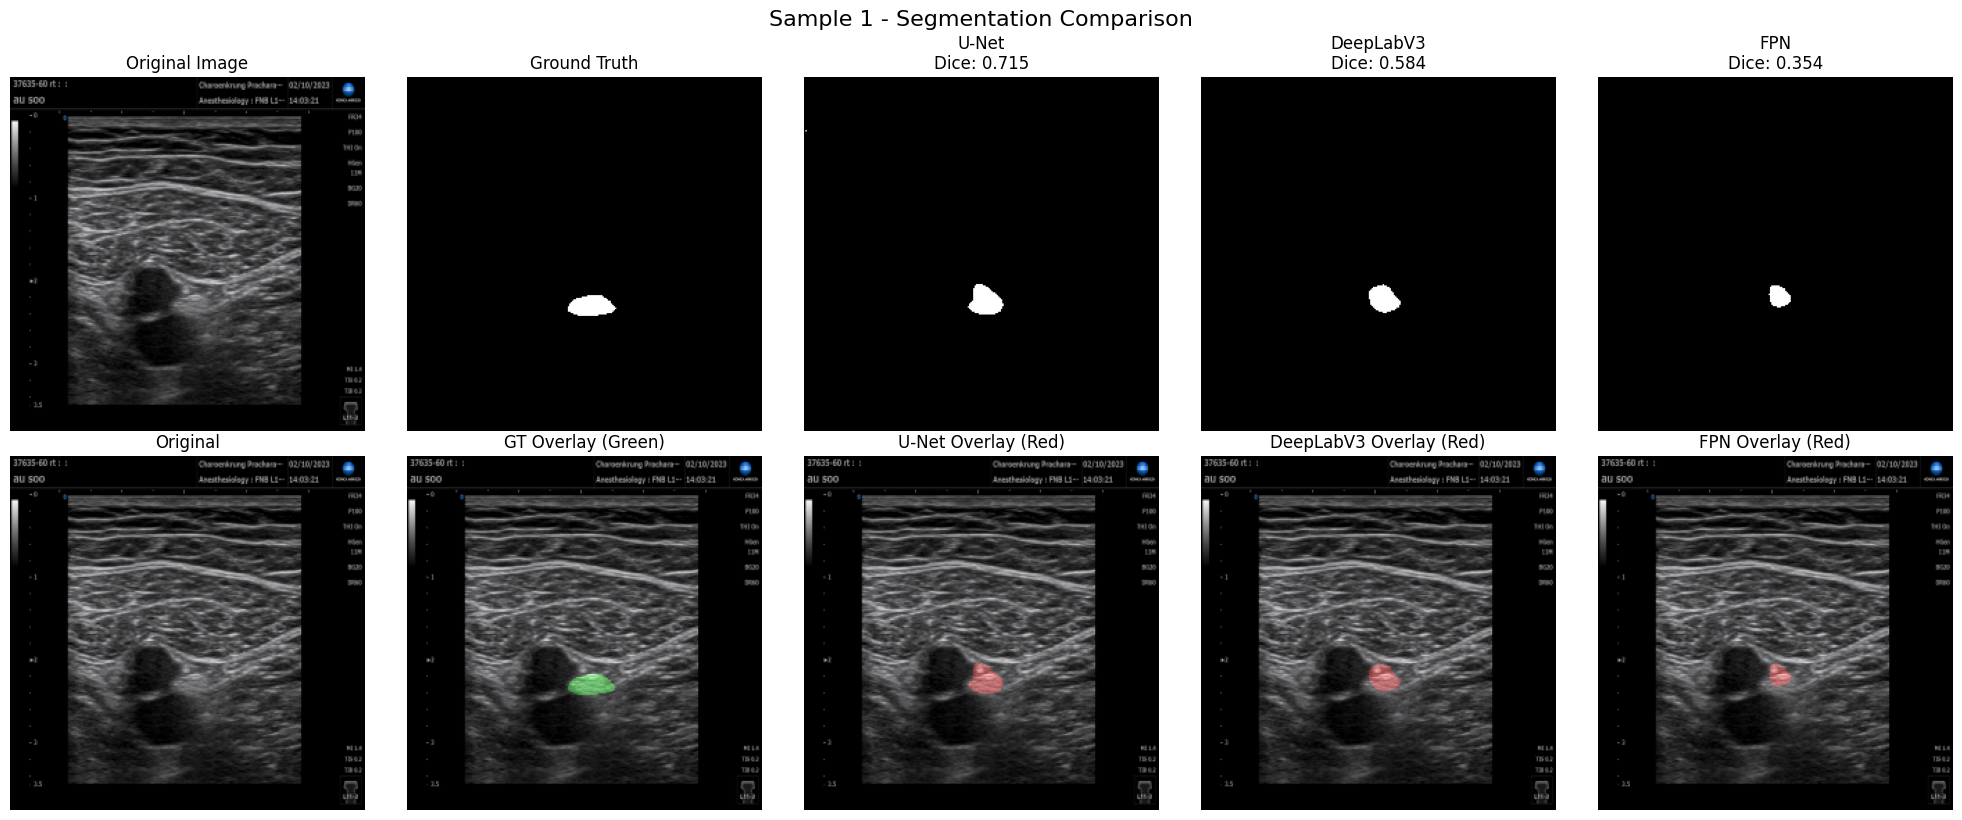

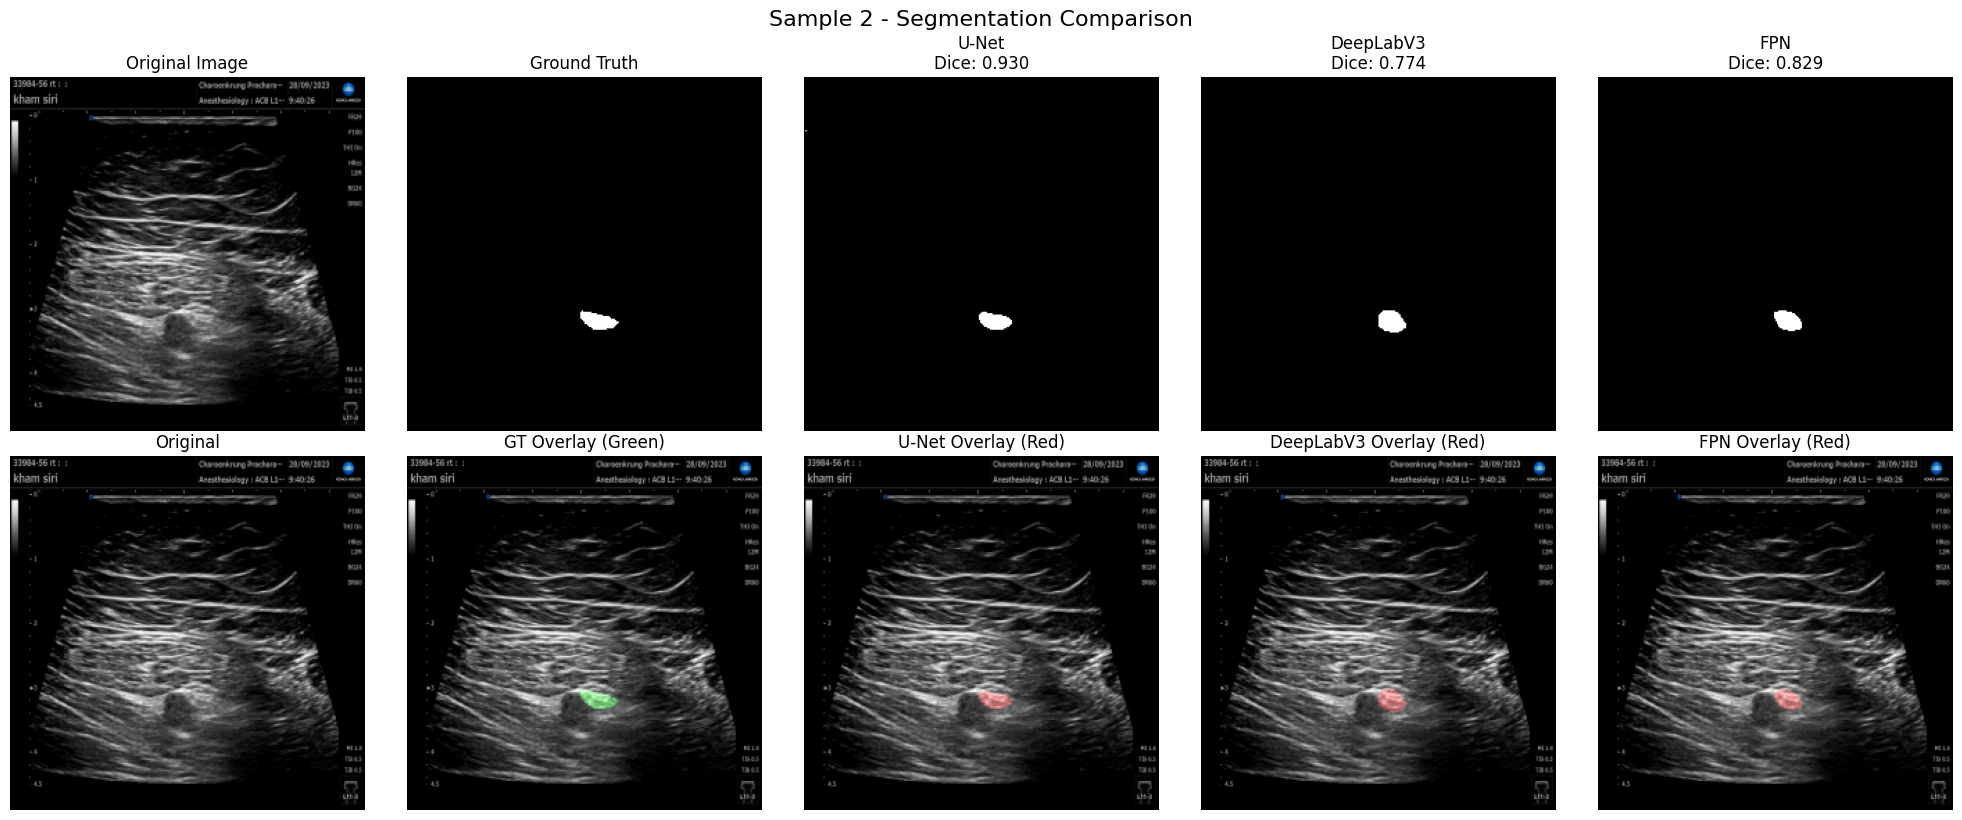

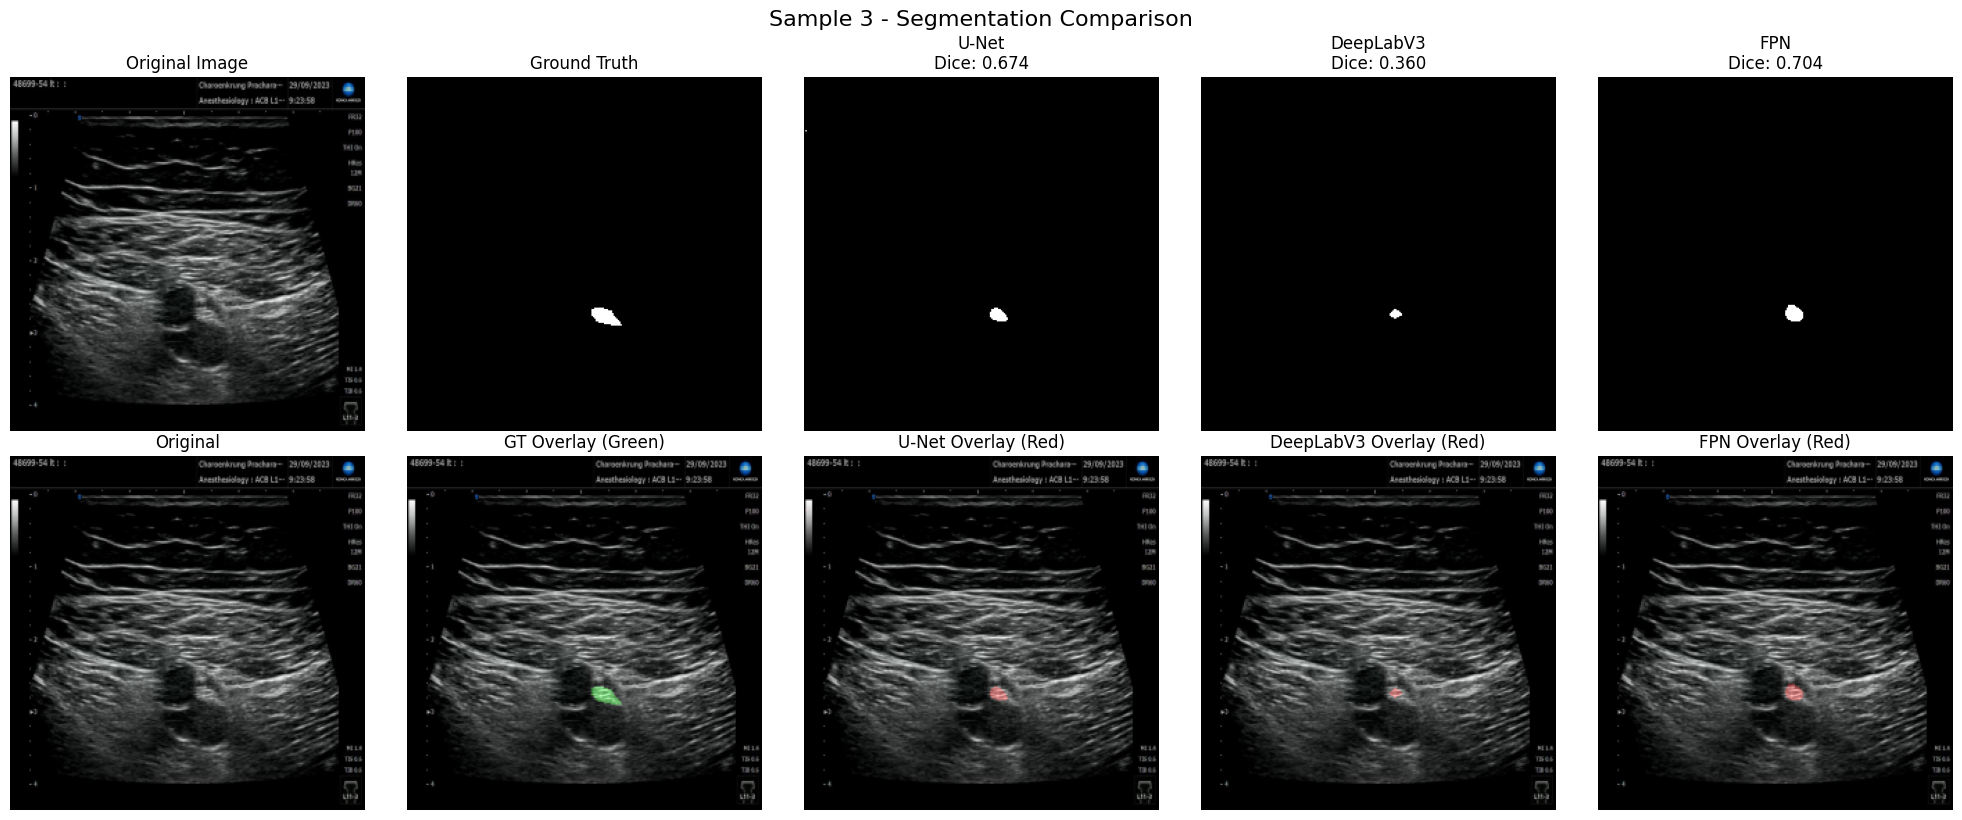


Analyzing best and worst performing cases...
Analyzing test set performance...


100%|██████████| 8/8 [00:01<00:00,  7.07it/s]



U-Net Performance Analysis:
Mean Dice: 0.807 ± 0.095
Best Dice: 0.930
Worst Dice: 0.585
Best cases indices: [ 1 13 14] with Dice scores: [0.92963755 0.92634559 0.92342341]
Worst cases indices: [21 32 57] with Dice scores: [0.5849387  0.59241706 0.62258953]


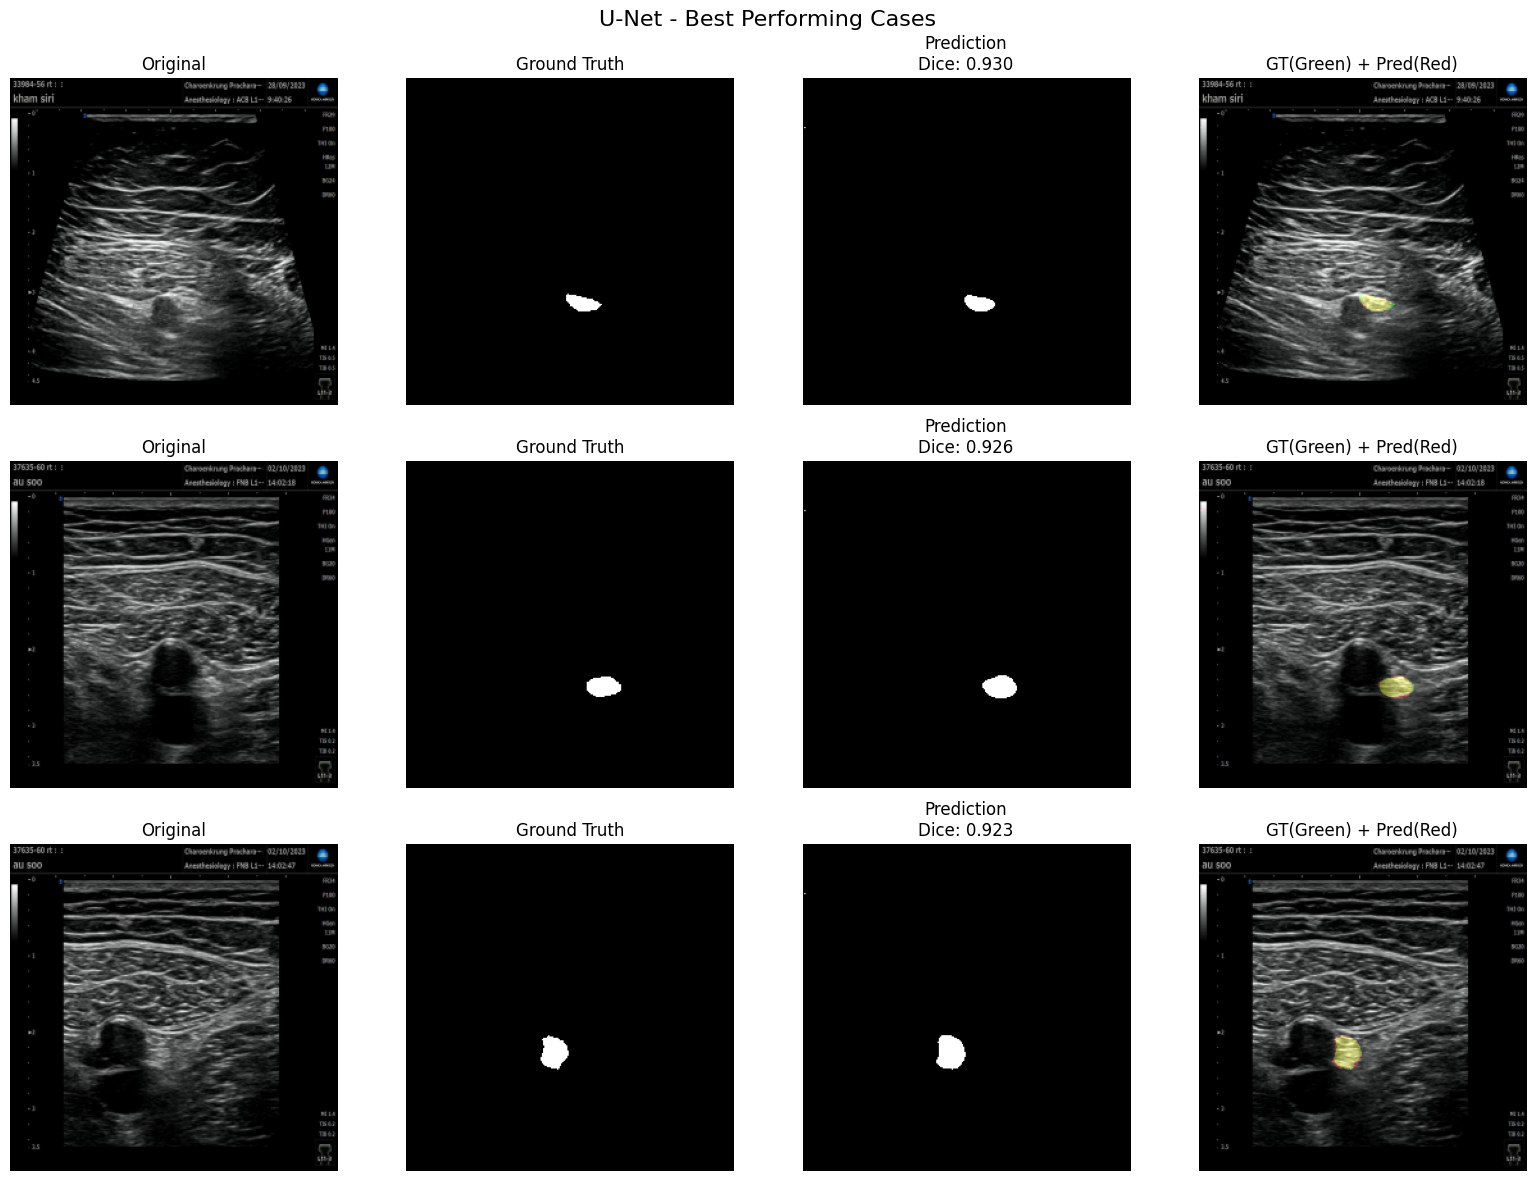

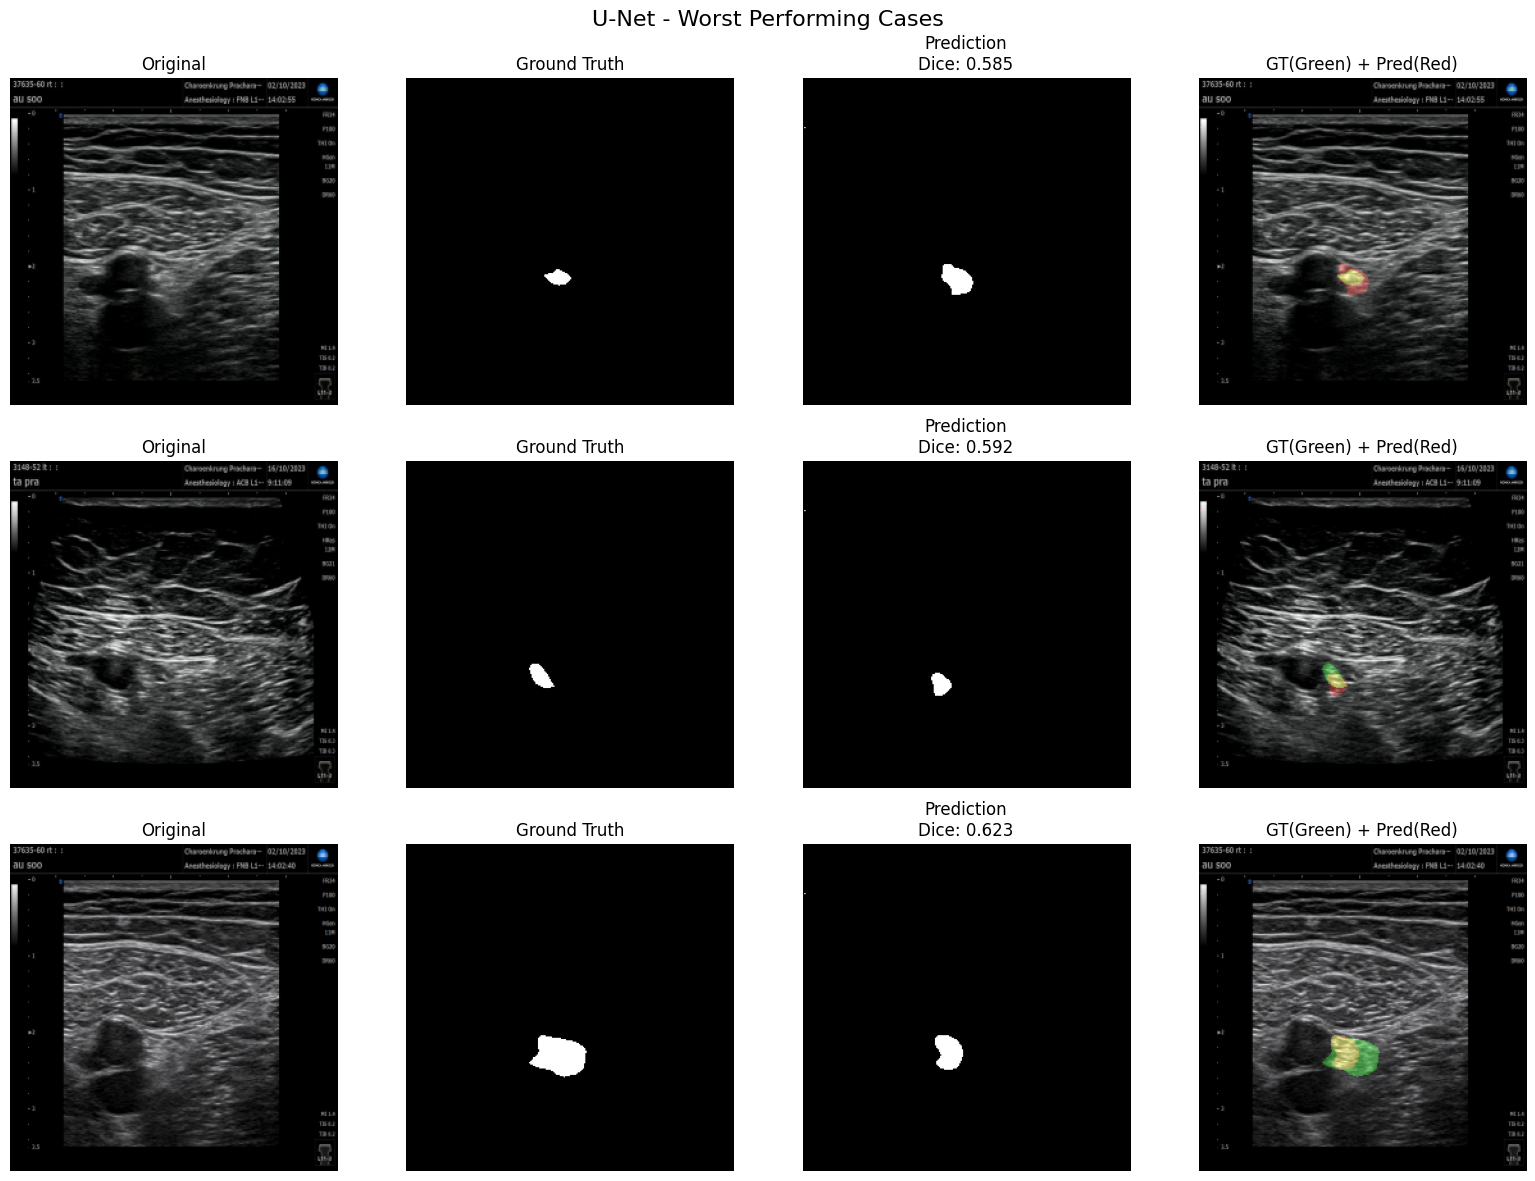


DeepLabV3 Performance Analysis:
Mean Dice: 0.716 ± 0.140
Best Dice: 0.897
Worst Dice: 0.315
Best cases indices: [50 47 45] with Dice scores: [0.89661014 0.86695278 0.86150908]
Worst cases indices: [39  2  3] with Dice scores: [0.31506848 0.36036035 0.39795917]


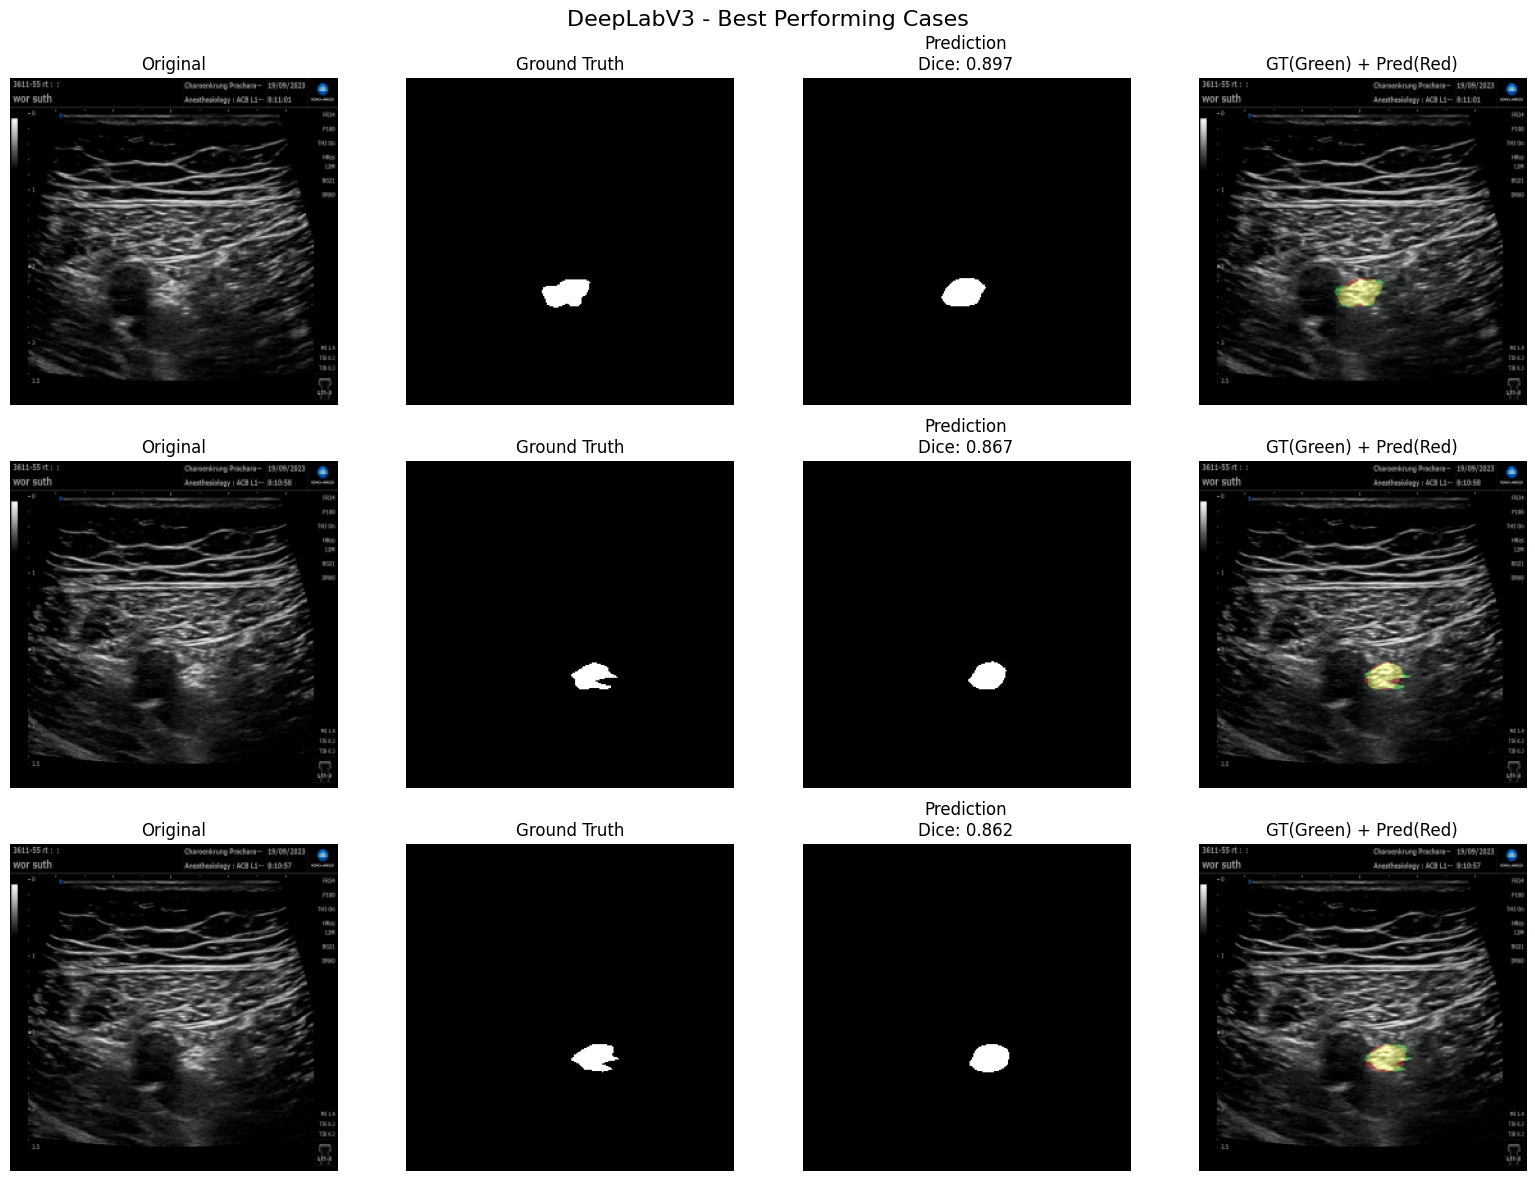

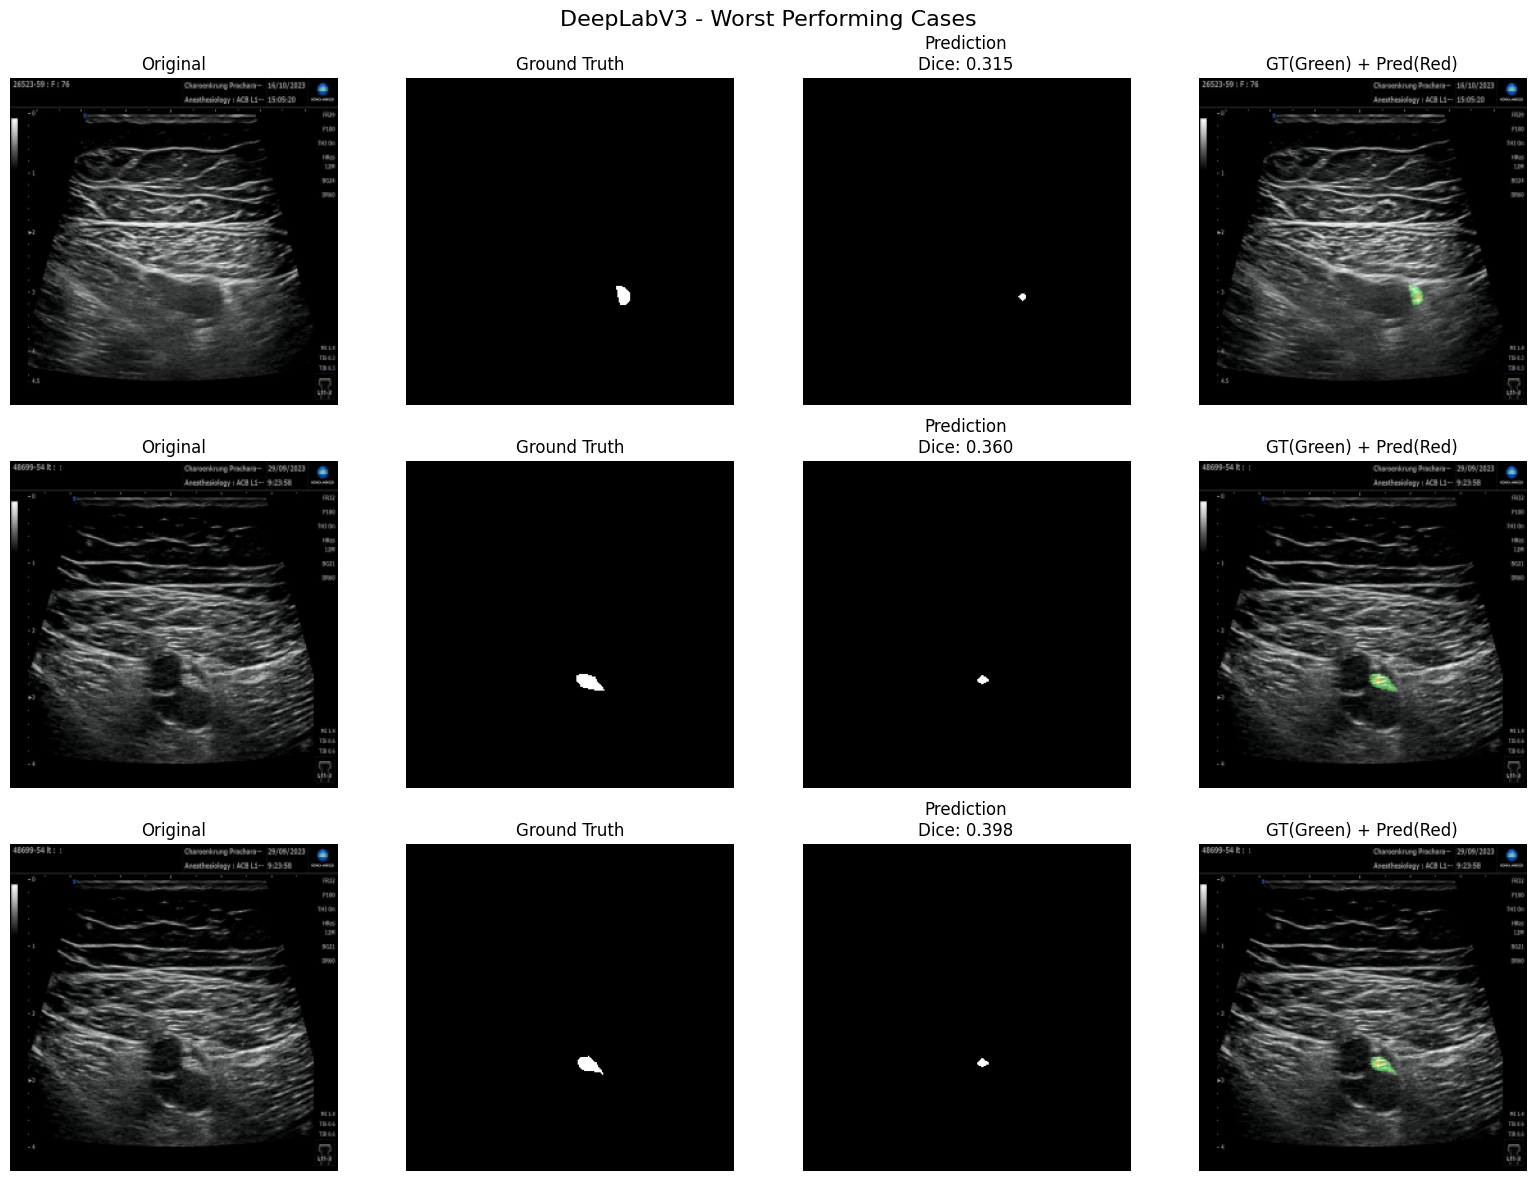


FPN Performance Analysis:
Mean Dice: 0.774 ± 0.105
Best Dice: 0.923
Worst Dice: 0.354
Best cases indices: [14 50 15] with Dice scores: [0.92307693 0.91456467 0.89773953]
Worst cases indices: [ 0 35 29] with Dice scores: [0.3537415  0.52927399 0.59036142]


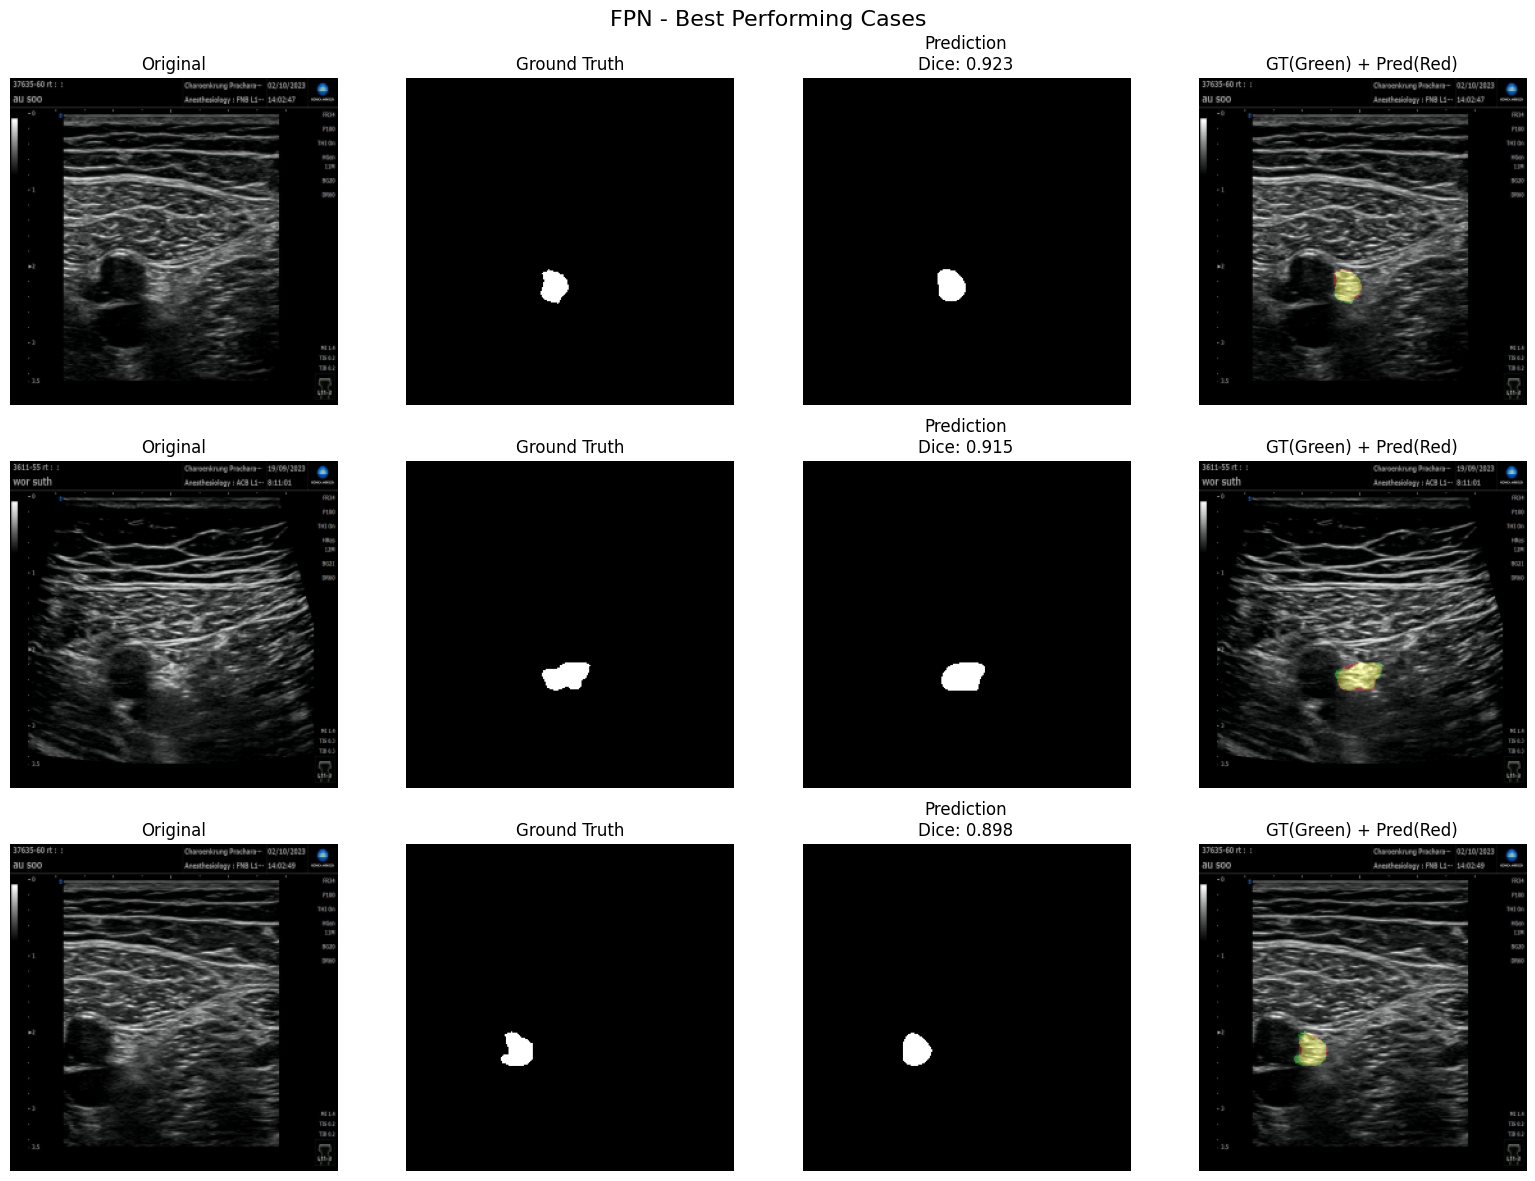

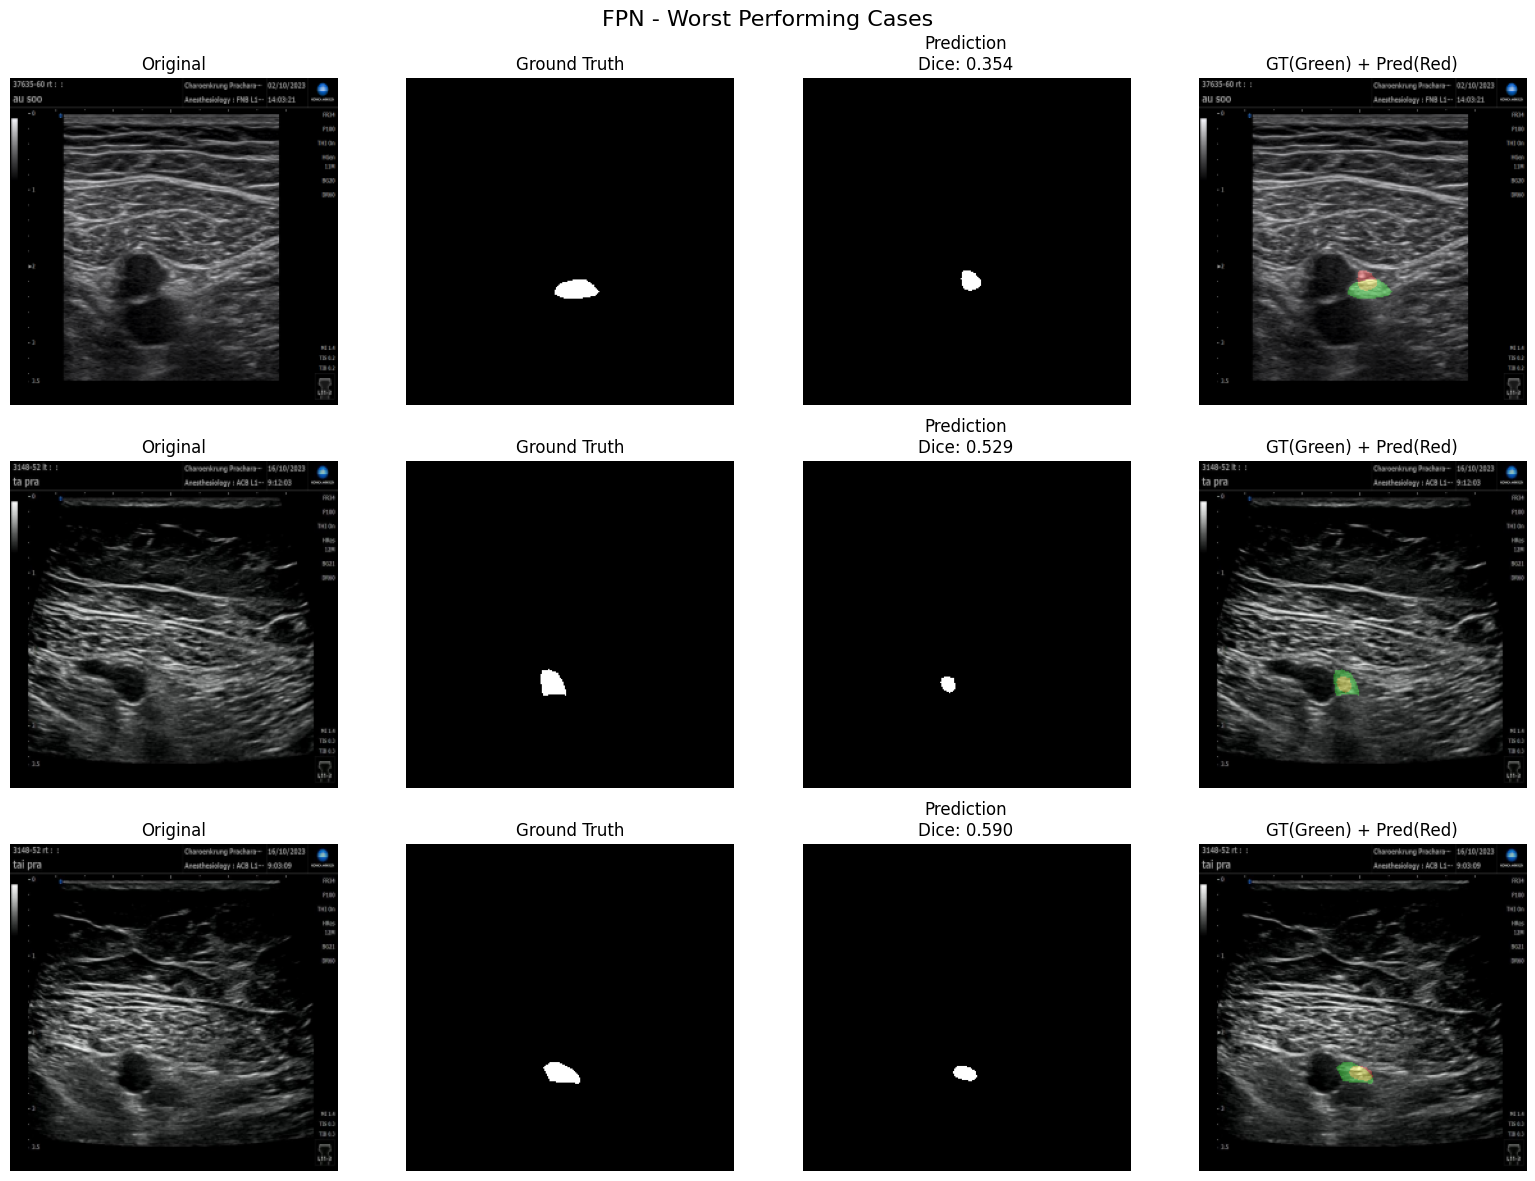

In [14]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
import os

# Load the best models
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load U-Net
unet_model = UNet().to(device)
unet_model.load_state_dict(torch.load("best_unet.pth"))
unet_model.eval()

# Load DeepLabV3
deeplab_model = DeepLabV3().to(device)
deeplab_model.load_state_dict(torch.load("best_deeplabv3.pth"))
deeplab_model.eval()

# Load FPN
fpn_model = FPNNet().to(device)
fpn_model.load_state_dict(torch.load("best_fpn.pth"))
fpn_model.eval()

def predict_and_visualize(models, test_loader, num_examples=6):
    """
    Visualize predictions from all models and compare them
    """
    model_names = ["U-Net", "DeepLabV3", "FPN"]
    
    # Get a batch of test data
    data_iter = iter(test_loader)
    images, masks = next(data_iter)
    images, masks = images.to(device), masks.to(device)
    
    # Get predictions from all models
    predictions = []
    dice_scores = []
    
    with torch.no_grad():
        for model in models:
            preds = model(images)
            predictions.append(preds.cpu())
            
            # Calculate dice scores for each image in batch
            batch_dice = []
            for i in range(preds.shape[0]):
                dice = dice_score(preds[i:i+1], masks[i:i+1])
                batch_dice.append(dice)
            dice_scores.append(batch_dice)
    
    # Select examples to show (best and worst performers)
    num_examples = min(num_examples, images.shape[0])
    
    for idx in range(num_examples):
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        
        # Original image
        img = images[idx].cpu()
        # Denormalize for display
        mean = torch.tensor([0.11803523, 0.12175034, 0.12110489]).view(3, 1, 1)
        std = torch.tensor([0.16351671, 0.16600904, 0.16600859]).view(3, 1, 1)
        img = img * std + mean
        img = torch.clamp(img, 0, 1)
        
        axes[0, 0].imshow(img.permute(1, 2, 0))
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')
        
        # Ground truth mask
        mask = masks[idx].cpu().squeeze()
        axes[0, 1].imshow(mask, cmap='gray')
        axes[0, 1].set_title('Ground Truth')
        axes[0, 1].axis('off')
        
        # Model predictions
        for i, (pred, name, dice_batch) in enumerate(zip(predictions, model_names, dice_scores)):
            pred_mask = (pred[idx].squeeze() > 0.5).float()
            axes[0, i+2].imshow(pred_mask, cmap='gray')
            axes[0, i+2].set_title(f'{name}\nDice: {dice_batch[idx]:.3f}')
            axes[0, i+2].axis('off')
        
        # Show overlays (prediction on original image)
        for i, (pred, name, dice_batch) in enumerate(zip(predictions, model_names, dice_scores)):
            # Create overlay
            overlay = img.permute(1, 2, 0).clone()
            pred_mask = (pred[idx].squeeze() > 0.5).float()
            
            # Add red overlay where prediction is positive
            overlay[:, :, 0] = torch.where(pred_mask > 0.5, 
                                         torch.clamp(overlay[:, :, 0] + 0.3, 0, 1), 
                                         overlay[:, :, 0])
            
            if i == 0:
                axes[1, 0].imshow(img.permute(1, 2, 0))
                axes[1, 0].set_title('Original')
                axes[1, 0].axis('off')
                
                # Ground truth overlay
                gt_overlay = img.permute(1, 2, 0).clone()
                gt_overlay[:, :, 1] = torch.where(mask > 0.5,
                                                torch.clamp(gt_overlay[:, :, 1] + 0.3, 0, 1),
                                                gt_overlay[:, :, 1])
                axes[1, 1].imshow(gt_overlay)
                axes[1, 1].set_title('GT Overlay (Green)')
                axes[1, 1].axis('off')
            
            axes[1, i+2].imshow(overlay)
            axes[1, i+2].set_title(f'{name} Overlay (Red)')
            axes[1, i+2].axis('off')
        
        plt.tight_layout()
        plt.suptitle(f'Sample {idx+1} - Segmentation Comparison', y=1.02, fontsize=16)
        plt.show()

def analyze_performance_cases(models, test_loader, threshold_good=0.8, threshold_bad=0.3):
    """
    Find and display best and worst performing cases
    """
    model_names = ["U-Net", "DeepLabV3", "FPN"]
    all_dice_scores = [[] for _ in range(len(models))]
    all_images = []
    all_masks = []
    all_predictions = [[] for _ in range(len(models))]
    
    print("Analyzing test set performance...")
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(tqdm(test_loader)):
            images, masks = images.to(device), masks.to(device)
            
            batch_predictions = []
            for model_idx, model in enumerate(models):
                preds = model(images)
                batch_predictions.append(preds.cpu())
                
                # Calculate dice for each image in batch
                for i in range(preds.shape[0]):
                    dice = dice_score(preds[i:i+1], masks[i:i+1])
                    all_dice_scores[model_idx].append(dice)
            
            # Store data for visualization
            all_images.extend([img.cpu() for img in images])
            all_masks.extend([mask.cpu() for mask in masks])
            for model_idx in range(len(models)):
                all_predictions[model_idx].extend([pred for pred in batch_predictions[model_idx]])
    
    # Convert to numpy for easier handling
    for model_idx in range(len(models)):
        all_dice_scores[model_idx] = np.array(all_dice_scores[model_idx])
    
    # Find best and worst cases for each model
    for model_idx, (model_name, dice_scores) in enumerate(zip(model_names, all_dice_scores)):
        print(f"\n{model_name} Performance Analysis:")
        print(f"Mean Dice: {dice_scores.mean():.3f} ± {dice_scores.std():.3f}")
        print(f"Best Dice: {dice_scores.max():.3f}")
        print(f"Worst Dice: {dice_scores.min():.3f}")
        
        # Find indices of best and worst cases
        best_indices = np.argsort(dice_scores)[-3:][::-1]  # Top 3
        worst_indices = np.argsort(dice_scores)[:3]        # Bottom 3
        
        print(f"Best cases indices: {best_indices} with Dice scores: {dice_scores[best_indices]}")
        print(f"Worst cases indices: {worst_indices} with Dice scores: {dice_scores[worst_indices]}")
        
        # Visualize best cases
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        fig.suptitle(f'{model_name} - Best Performing Cases', fontsize=16)
        
        for i, idx in enumerate(best_indices):
            # Original image
            img = all_images[idx]
            mean = torch.tensor([0.11803523, 0.12175034, 0.12110489]).view(3, 1, 1)
            std = torch.tensor([0.16351671, 0.16600904, 0.16600859]).view(3, 1, 1)
            img = img * std + mean
            img = torch.clamp(img, 0, 1)
            
            axes[i, 0].imshow(img.permute(1, 2, 0))
            axes[i, 0].set_title('Original')
            axes[i, 0].axis('off')
            
            # Ground truth
            mask = all_masks[idx].squeeze()
            axes[i, 1].imshow(mask, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            # Prediction
            pred = (all_predictions[model_idx][idx].squeeze() > 0.5).float()
            axes[i, 2].imshow(pred, cmap='gray')
            axes[i, 2].set_title(f'Prediction\nDice: {dice_scores[idx]:.3f}')
            axes[i, 2].axis('off')
            
            # Overlay
            overlay = img.permute(1, 2, 0).clone()
            # Green for GT, Red for prediction
            overlay[:, :, 1] = torch.where(mask > 0.5,
                                         torch.clamp(overlay[:, :, 1] + 0.3, 0, 1),
                                         overlay[:, :, 1])
            overlay[:, :, 0] = torch.where(pred > 0.5,
                                         torch.clamp(overlay[:, :, 0] + 0.3, 0, 1),
                                         overlay[:, :, 0])
            axes[i, 3].imshow(overlay)
            axes[i, 3].set_title('GT(Green) + Pred(Red)')
            axes[i, 3].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Visualize worst cases
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        fig.suptitle(f'{model_name} - Worst Performing Cases', fontsize=16)
        
        for i, idx in enumerate(worst_indices):
            # Original image
            img = all_images[idx]
            mean = torch.tensor([0.11803523, 0.12175034, 0.12110489]).view(3, 1, 1)
            std = torch.tensor([0.16351671, 0.16600904, 0.16600859]).view(3, 1, 1)
            img = img * std + mean
            img = torch.clamp(img, 0, 1)
            
            axes[i, 0].imshow(img.permute(1, 2, 0))
            axes[i, 0].set_title('Original')
            axes[i, 0].axis('off')
            
            # Ground truth
            mask = all_masks[idx].squeeze()
            axes[i, 1].imshow(mask, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            # Prediction
            pred = (all_predictions[model_idx][idx].squeeze() > 0.5).float()
            axes[i, 2].imshow(pred, cmap='gray')
            axes[i, 2].set_title(f'Prediction\nDice: {dice_scores[idx]:.3f}')
            axes[i, 2].axis('off')
            
            # Overlay
            overlay = img.permute(1, 2, 0).clone()
            # Green for GT, Red for prediction
            overlay[:, :, 1] = torch.where(mask > 0.5,
                                         torch.clamp(overlay[:, :, 1] + 0.3, 0, 1),
                                         overlay[:, :, 1])
            overlay[:, :, 0] = torch.where(pred > 0.5,
                                         torch.clamp(overlay[:, :, 0] + 0.3, 0, 1),
                                         overlay[:, :, 0])
            axes[i, 3].imshow(overlay)
            axes[i, 3].set_title('GT(Green) + Pred(Red)')
            axes[i, 3].axis('off')
        
        plt.tight_layout()
        plt.show()

# Run the visualizations
models = [unet_model, deeplab_model, fpn_model]

print("Generating comparison visualizations...")
predict_and_visualize(models, test_loader, num_examples=3)

print("\nAnalyzing best and worst performing cases...")
analyze_performance_cases(models, test_loader)